## Imports

In [15]:
import os, time, timeit, json, torch, mat73, argparse
import numpy as np, pandas as pd
from scipy.signal import resample
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from torch import nn
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from aeon.classification.deep_learning import InceptionTimeClassifier
from aeon.networks import InceptionNetwork
from aeon.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.distance_based import ProximityForest
from aeon.classification.feature_based import Catch22Classifier
from aeon.classification.interval_based import DrCIFClassifier
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

from sktime.transformations.panel.rocket import Rocket, MiniRocket, MultiRocket
from sktime.classification.feature_based import Catch22Classifier
from sktime.transformations.panel.catch22 import Catch22

from scripts.hydra import Hydra, SparseScaler


%load_ext autoreload
%autoreload 2
from scripts import farseeing #, deep_learning_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Train set: X: (693, 2750), y: (693,)    ([ADLs, Falls]) [599  94]
Test set: X: (516, 2750), y: (516,)    ([ADLs, Falls]) [465  51]


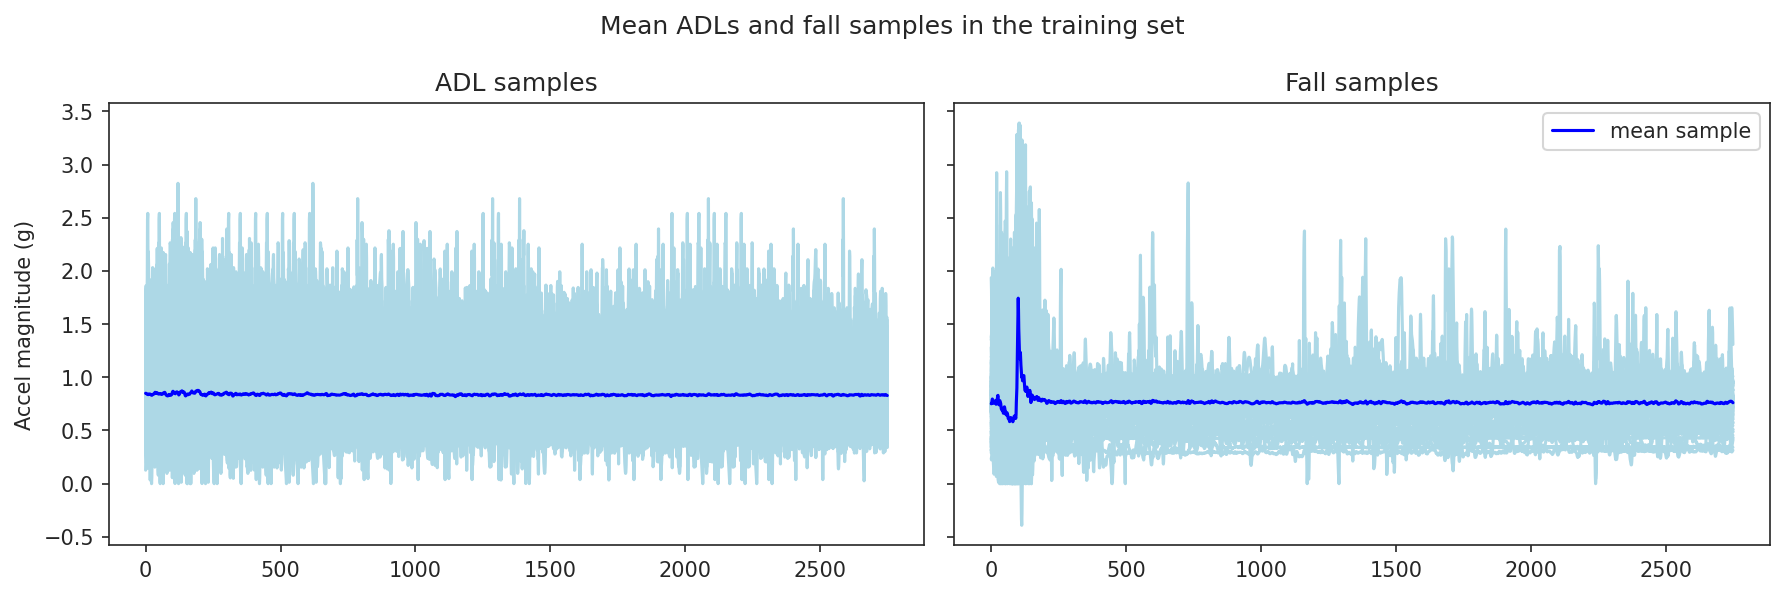

In [24]:
X_train, y_train, X_test, y_test = farseeing.train_test_subjects_split()

In [3]:
meta.Pre_fall_activity_reported.unique()

array(['transfer', 'walking', 'bending down', 'Standing up/walking',
       'standing', 'walking, standing', 'unknown', 'dressing',
       'standing up', 'stand up/ standing', 'transfer, start walking',
       'stand up, walking', 'lying', 'stand up', 'turning', 'Bending',
       'sitting down', 'walking backward', 'walking, stair climbing',
       'walking, standing up', 'sitting',
       'presumably standing up from bed', 'walking, sitting down', 'Walk',
       'Sitting on the seat', 'standing, transfer',
       'standing up from an armchair', 'standing / grasping',
       'walking forward', 'sit to stand transition from sofa',
       'walking initiation', 'stand to sit transition',
       'standing, turning left', 'standing, turning, grasping',
       'standing/grasping', 'standing/walking with turning', 'bending',
       'walking backwards', 'sit to stand transition armchair',
       'kneeling', 'standing up from the toilet', 'standing/turning',
       'standing up/walking', 'sitti

In [4]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

signal_files = os.listdir(r'data/FARSEEING/signals')
falls_dict = {}
for sf in signal_files:
    p, ID = sf[2:].split('-')[:2]
    if p in falls_dict:
        falls_dict[p].append(sf)
    else:
        falls_dict[p] = [sf]

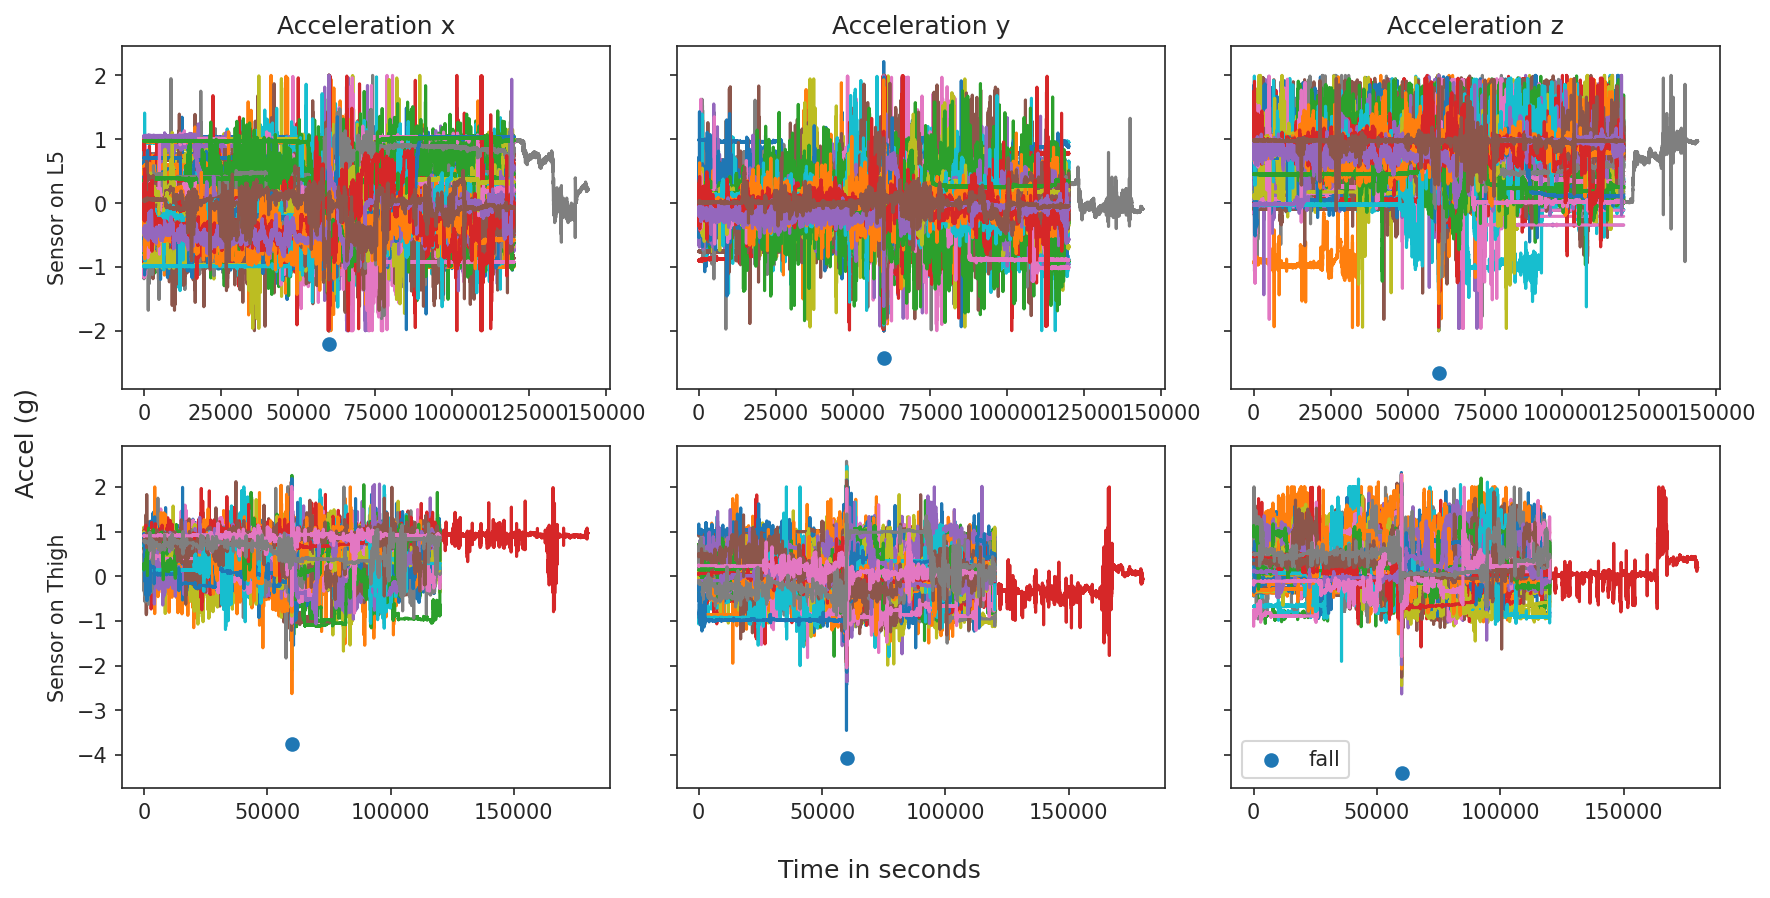

In [5]:
fig, axs = plt.subplots(2,3, figsize=(12,6), dpi=150, sharey='row')
for sf in signal_files:
    fall_id = '-'.join(sf.split("_")[1].split("-")[:2])
    row = meta[meta['Randomnumber']==fall_id]
    freq = row['Sample_rate_Hz'].item()
    signal = mat73.loadmat(f'data/FARSEEING/signals/{sf}')
    time = signal['tmp'][:,0]
    accel = signal['tmp'][:,2:5]/9.8
    accel_norm = np.clip(accel, -2, 2)
    labels = ['x','y','z']
    for i, sig in enumerate(accel_norm.T):
        if freq == 20: # resample to make freq=100Hz
            sig = resample(sig, 120000)
        if row['Sensor_location'].item() == 'L5':
            axs[0,i].plot(sig)
        else:
            axs[1,i].plot(sig)
        axs[0,i].set_title(f'Acceleration {labels[i]}')
for ax in axs.flatten():
    ymin, ymax = ax.get_ylim()
    ax.scatter(60000, ymin, label='fall')
fig.supylabel(r'Accel (g)')
fig.supxlabel('Time in seconds')
axs[0,0].set_ylabel('Sensor on L5')
axs[1,0].set_ylabel('Sensor on Thigh')
fig.tight_layout()
plt.legend()
plt.show()

In [6]:
subjects = list(falls_dict.keys())
# Have 65 subjects for training, 27 for testing
test_set = ['74827807', '74905787', '75240038', '76573505', '79232001', '79336438', '79666043', '79761947', '80061866', '87486959', '88051353', '89647122', '91923026', '91943076', '92097726', '92680167', '93169462', '93807530', '95030446', '95205003', '95253031', '96201346', '96856291', '97085274', '97097674', '97946301', '98843998']
train_set = list(set(subjects) - set(test_set))
X_train = []; y_train = [];
X_test = []; y_test = [];
pip = 27

# fig, axs = plt.subplots(1,3, figsize=(12,4), dpi=150, sharey=True)
for sf in signal_files:
    if sf == "F_00002186-05-2013-11-23-18-25-04.mat":
        continue
    fall_id = '-'.join(sf.split("_")[1].split("-")[:2])
    row = meta[meta['Randomnumber']==fall_id]
    if row['Sensor_location'].item() != 'L5':
        continue
    subject = fall_id.split("-")[0]
    test = subject in test_set
    freq = row['Sample_rate_Hz'].item()
    signal = mat73.loadmat(f'data/FARSEEING/signals/{sf}')
    time = signal['tmp'][:,0]
    accel = signal['tmp'][:,2:5]/9.8
    accel_magnitude = utils.magnitude(np.clip(accel, -2, 2))
    fall_indicator = signal['tmp'][:,11]
    fall_point = np.where(fall_indicator!=0)[0][0]
    end_with_padding = len(accel_magnitude) - int(freq * 7)
    # extract the fall out of the signal
    # 1 sec before, and 26.5 secs after
    before = int(fall_point-(freq*1))
    after = int(fall_point+(freq*6))
    fall_signal = accel_magnitude[before:after]
    prefall_signal = accel_magnitude[:before]
    # postfall_signal = accel_magnitude[after:]
    # Segment fall_signal
    X_train, X_test, y_train, y_test = utils.get_windows(
        X_train, X_test, y_train, y_test, fall_signal, freq,
        target=1, test=test, postfall=6)
    # Segment prefall_signal
    X_train, X_test, y_train, y_test = utils.get_windows(
        X_train, X_test, y_train, y_test, prefall_signal, freq,
        target=0, thresh=1.4, test=test,
        postfall=6)
X_train_old = np.array(X_train)
y_train_old = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(f"Train set: X: {X_train_old.shape}, y: {y_train_old.shape}\
([ADLs, Falls])", np.bincount(y_train_old))
print(f"Test set: X: {X_test.shape}, y: {y_test.shape}\
([ADLs, Falls])", np.bincount(y_test))

Train set: X: (764, 700), y: (764,)([ADLs, Falls]) [670  94]
Test set: X: (550, 700), y: (550,)([ADLs, Falls]) [499  51]


In [17]:
# Group falls and ADLs together to sample from ADLs
X_train_y_train = np.concatenate([X_train_old,
                                  y_train_old.reshape(-1,1)],
                                 axis=1)
X_train_falls = X_train_y_train[X_train_y_train[:,-1]==1]
X_train_ADLs = X_train_y_train[X_train_y_train[:,-1]==0]
np.random.seed(5)
rng = np.random.default_rng()
rng.shuffle(X_train_ADLs)
# Select 599 ADLs
X_train_ADLs_with_labels = X_train_ADLs[:599]
X_train_rejoined = np.concatenate([X_train_ADLs_with_labels,
                                   X_train_falls], axis=0)
rng.shuffle(X_train_rejoined) # shuffle again
# recover X_train and y_train
X_train = X_train_rejoined[:,:700]
y_train = X_train_rejoined[:,-1].astype(int)
print(f"Train set: X: {X_train.shape}, y: {y_train.shape}\
([ADLs, Falls])", np.bincount(y_train))
print(f"Test set: X: {X_test.shape}, y: {y_test.shape}\
([ADLs, Falls])", np.bincount(y_test))

Train set: X: (693, 700), y: (693,)([ADLs, Falls]) [599  94]
Test set: X: (550, 700), y: (550,)([ADLs, Falls]) [499  51]


In [22]:
print(X_train.tolist()[:50])

[[0.8168003762027047, 0.8072739151067372, 0.8013227687271212, 0.7965573642754108, 0.7929306358721755, 0.7816412861836775, 0.7620579769392637, 0.7429907115791056, 0.7243420452709133, 0.7107874462565885, 0.6986419586423511, 0.6937826181461996, 0.697580549603146, 0.71595533768756, 0.7722084927989528, 0.8918449204999848, 1.0956535041538966, 1.3607187124851419, 1.6123442295147192, 1.7541190569105902, 1.6643821127182288, 1.4180718796368963, 1.1154426588424848, 0.8195829244200334, 0.6034122603192964, 0.5134099728698654, 0.47174541128958636, 0.3868889713010615, 0.37532540653554025, 0.4274450480432217, 0.523533106271449, 0.6504801618274473, 0.8033288370277383, 0.9793696119680986, 1.1222843849564392, 1.1801369098049561, 1.1481258245576542, 1.0628595492541661, 0.9553901483314653, 0.8563050088977533, 0.7803474562036726, 0.7363861511353934, 0.7200895410270911, 0.7355063398429801, 0.7667146844353201, 0.807077128549964, 0.8515746863147158, 0.8847725225246754, 0.8886458865401641, 0.860373903270498, 0.

In [8]:
X_train = np.array(X_train)[:, np.newaxis, :]
y_train = np.array(y_train)
X_test = np.array(X_test)[:, np.newaxis, :]
y_test = np.array(y_test)
print(f"Train set: X: {X_train.shape}, y: {y_train.shape}\
([ADLs, Falls])", np.bincount(y_train))
print(f"Test set: X: {X_test.shape}, y: {y_test.shape}\
([ADLs, Falls])", np.bincount(y_test))

Train set: X: (693, 1, 700), y: (693,)([ADLs, Falls]) [599  94]
Test set: X: (550, 1, 700), y: (550,)([ADLs, Falls]) [499  51]


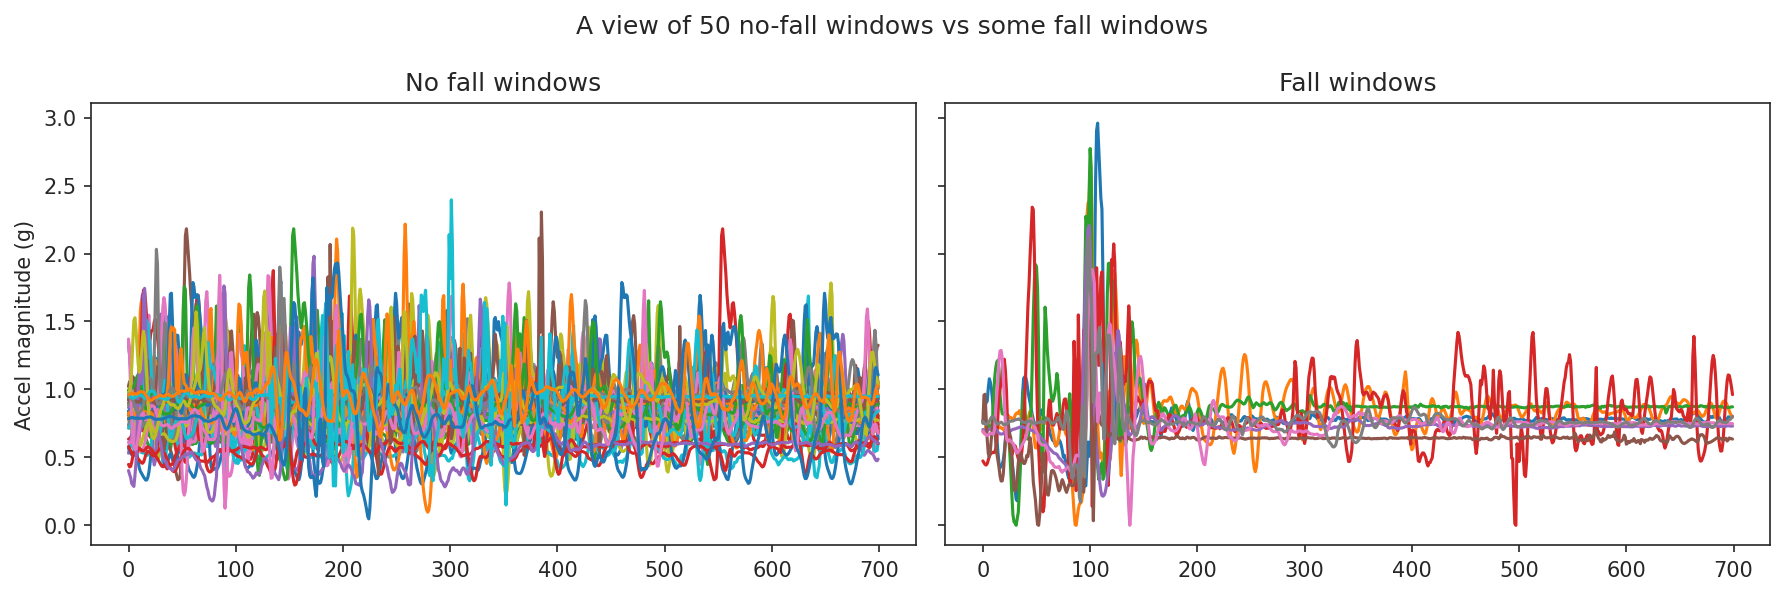

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=150,
                        sharey=True, layout='tight')
for i, target in enumerate(y_train[:50]):
    if target:
        axs[1].plot(X_train.squeeze()[:50][i])
    else:
        axs[0].plot(X_train.squeeze()[:50][i])
axs[0].set_title('No fall windows')
axs[1].set_title('Fall windows')
axs[0].set_ylabel('Accel magnitude (g)')
fig.suptitle("A view of 50 no-fall windows vs some fall windows")
plt.show()

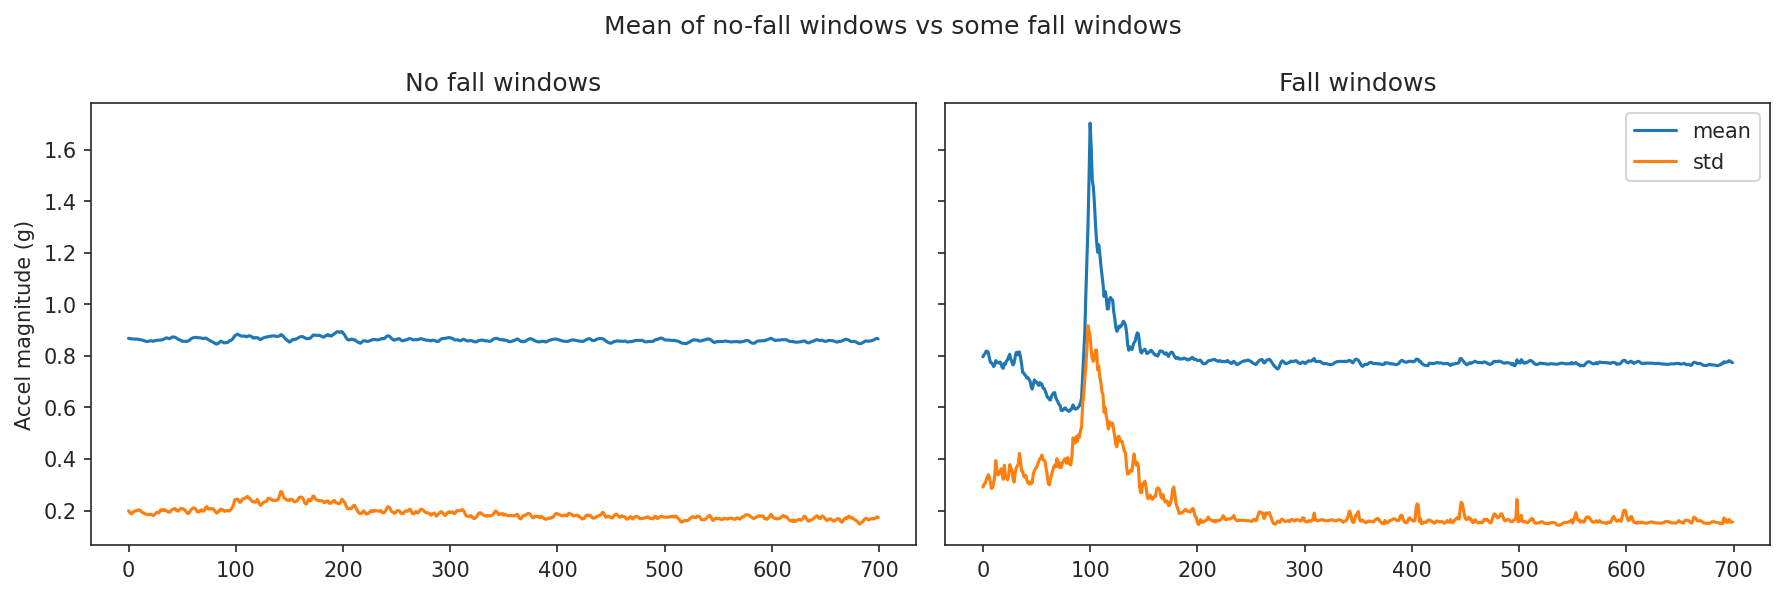

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=150,
                        sharey=True, layout='tight')
adls = []
falls = []
for X, y in [(X_train.squeeze(), y_train), (X_test.squeeze(), y_test)]:
    for i, target in enumerate(y):
        if target:
            falls.append(X[i])
        else:
            adls.append(X[i])
falls = np.array(falls)
adls = np.array(adls)
axs[0].plot(np.mean(adls, axis=0), label='mean')
axs[0].plot(np.std(adls, axis=0), label='std')
axs[1].plot(np.mean(falls, axis=0), label='mean')
axs[1].plot(np.std(falls, axis=0), label='std')
axs[0].set_title('No fall windows')
axs[1].set_title('Fall windows')
axs[0].set_ylabel('Accel magnitude (g)')
fig.suptitle("Mean of no-fall windows vs some fall windows")
plt.legend()
plt.show()

## Time Series Classifiers

### Hydra

classifier: Hydra+RidgeCV
Time to train + test (sec): 4.769656615331769
Skipping AUC since chosen classifier has no predict_proba() method


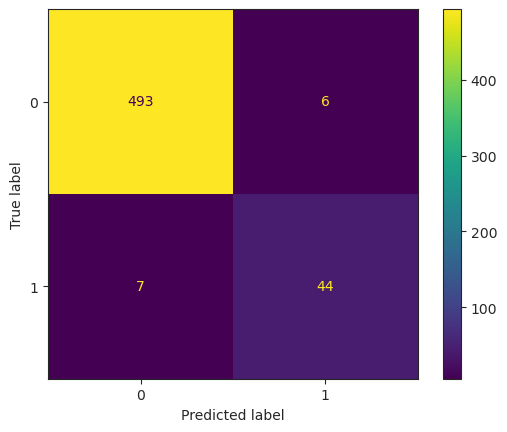

              precision    recall  f1-score   support

         ADL       0.99      0.99      0.99       499
        Fall       0.88      0.86      0.87        51

    accuracy                           0.98       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.98      0.98      0.98       550

classifier: Hydra+XTrees
Time to train + test (sec): 4.944658937864006
AUC: 0.99


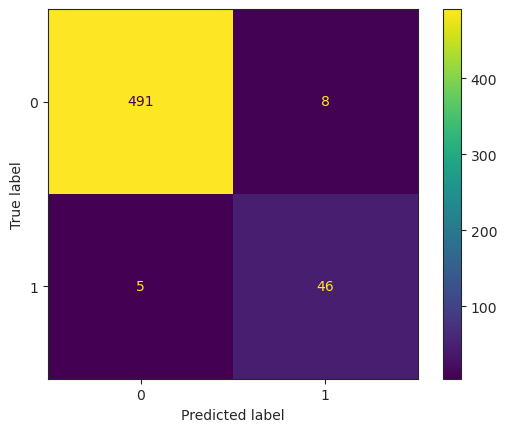

              precision    recall  f1-score   support

         ADL       0.99      0.98      0.99       499
        Fall       0.85      0.90      0.88        51

    accuracy                           0.98       550
   macro avg       0.92      0.94      0.93       550
weighted avg       0.98      0.98      0.98       550



In [15]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

ridge_clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
xtrees_clf = ExtraTreesClassifier(n_estimators = 150, max_features = 0.1,
                                  criterion="entropy", n_jobs=-1,
                                  random_state=0)
hydra_models = [("Hydra+RidgeCV", ridge_clf), ("Hydra+XTrees", xtrees_clf)]
for hydra_model in hydra_models:
    start = timeit.default_timer()
    hydra_transform = Hydra(X_train_torch.shape[-1])
    X_training_transform = hydra_transform(X_train_torch)
    X_test_transform = hydra_transform(X_test_torch)

    scaler = SparseScaler()
    X_training_transform = scaler.fit_transform(X_training_transform)
    X_test_transform = scaler.transform(X_test_transform)
    utils.predict_eval(hydra_model, X_in=(X_training_transform, X_test_transform),
                            y_in=(y_train, y_test), starttime=start)                

### Rocket

classifier: Rocket+RidgeCV
Time to train + test (sec): 55.968432827852666
Skipping AUC since chosen classifier has no predict_proba() method


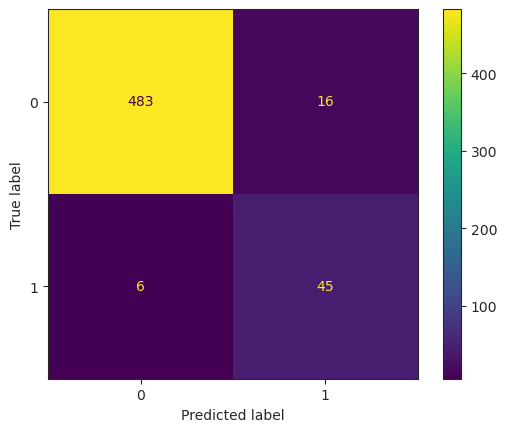

              precision    recall  f1-score   support

         ADL       0.99      0.97      0.98       499
        Fall       0.74      0.88      0.80        51

    accuracy                           0.96       550
   macro avg       0.86      0.93      0.89       550
weighted avg       0.96      0.96      0.96       550

classifier: Rocket+XTrees
Time to train + test (sec): 50.42009879369289
AUC: 0.98


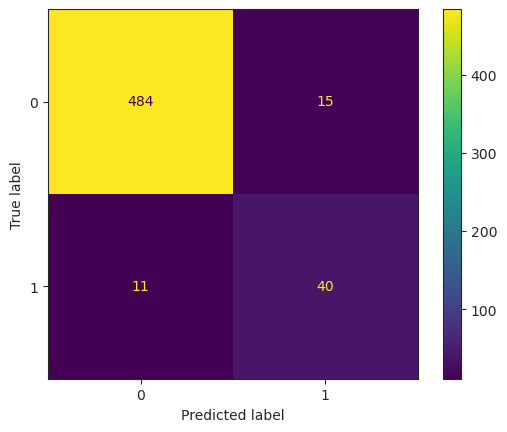

              precision    recall  f1-score   support

         ADL       0.98      0.97      0.97       499
        Fall       0.73      0.78      0.75        51

    accuracy                           0.95       550
   macro avg       0.85      0.88      0.86       550
weighted avg       0.95      0.95      0.95       550



In [16]:
ridge_clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
xtrees_clf = ExtraTreesClassifier(n_estimators = 150, criterion="entropy", n_jobs=-1,
                                  random_state=0)
rocket_models = [("Rocket+RidgeCV", ridge_clf), ("Rocket+XTrees", xtrees_clf)]
for rocket_model in rocket_models:
    start = timeit.default_timer()
    rocket = Rocket().fit(X_train)
    X_train_transform = rocket.transform(X_train)
    X_test_transform = rocket.transform(X_test)
    # scaler = SparseScaler()
    # X_training_transform = scaler.fit_transform(X_training_transform)
    # X_test_transform = scaler.transform(X_test_transform)
    utils.predict_eval(rocket_model, X_in=(X_train_transform, X_test_transform),
                            y_in=(y_train, y_test), starttime=start)

### Rocket+Hydra

classifier: HydRock+RidgeCV
Time to train + test (sec): 56.03733308054507
Skipping AUC since chosen classifier has no predict_proba() method


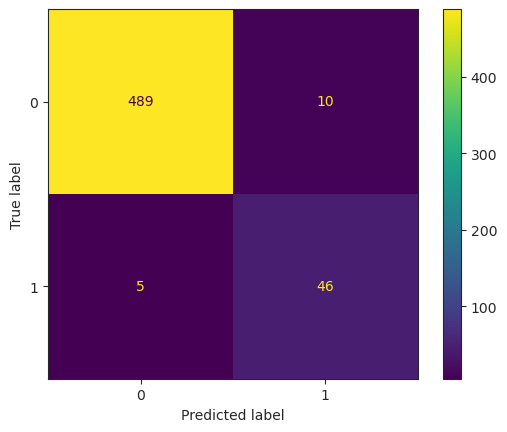

              precision    recall  f1-score   support

         ADL       0.99      0.98      0.98       499
        Fall       0.82      0.90      0.86        51

    accuracy                           0.97       550
   macro avg       0.91      0.94      0.92       550
weighted avg       0.97      0.97      0.97       550

classifier: HydRock+XTrees
Time to train + test (sec): 56.62478972133249
AUC: 0.99


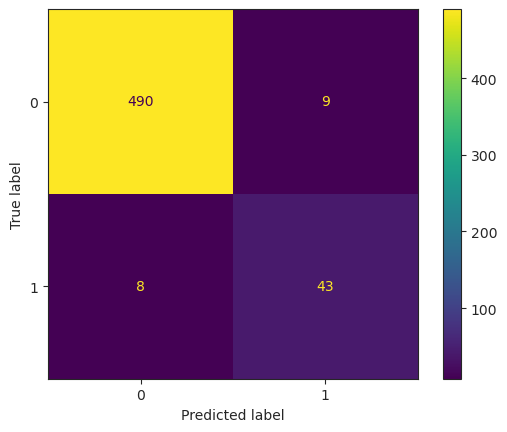

              precision    recall  f1-score   support

         ADL       0.98      0.98      0.98       499
        Fall       0.83      0.84      0.83        51

    accuracy                           0.97       550
   macro avg       0.91      0.91      0.91       550
weighted avg       0.97      0.97      0.97       550



In [17]:
def hydrock(X, y):
  X_train, X_test = X
  y_train, y_test = y
  X_train_torch = torch.tensor(X_train, dtype=torch.float32)
  X_test_torch = torch.tensor(X_test, dtype=torch.float32)
  hydra_transform = Hydra(X_train_torch.shape[-1])
  X_train_hydra = hydra_transform(X_train_torch)
  X_test_hydra = hydra_transform(X_test_torch)
  scaler = SparseScaler()
  X_train_hydra = scaler.fit_transform(X_train_hydra).numpy()
  X_test_hydra = scaler.transform(X_test_hydra).numpy()

  rocket = Rocket().fit(X_train)
  X_train_rocket = rocket.transform(X_train).to_numpy()
  X_test_rocket = rocket.transform(X_test).to_numpy()

  X_train_concat = np.hstack([X_train_hydra, X_train_rocket])
  X_test_concat = np.hstack([X_test_hydra, X_test_rocket])

  return X_train_concat, X_test_concat, y_train, y_test

ridge_clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
xtrees_clf = ExtraTreesClassifier(n_estimators = 150, criterion="entropy", n_jobs=-1,
                                  random_state=0)
hydrock_models = [("HydRock+RidgeCV", ridge_clf), ("HydRock+XTrees", xtrees_clf)]
for hydrock_model in hydrock_models:
    start = timeit.default_timer()
    X_train_transform, X_test_transform, y_train, y_test = hydrock(
       (X_train, X_test), (y_train, y_test))
    utils.predict_eval(hydrock_model, X_in=(X_train_transform, X_test_transform),
                            y_in=(y_train, y_test), starttime=start)
    

### ConvTran

In [11]:
ConvTran = deep_learning_models.train_ConvTran
ConvTran("farseeing", 2, X_train, y_train, X_test, y_test)

2024-05-23 11:00:57,928 | INFO : Using device: cuda
/home/timiderinola/miniconda3/envs/msca/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training Epoch:   0%|                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]/home/timiderinola/miniconda3/envs/msca/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,
/home/timiderinola/miniconda3/envs/msca/lib/p

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 599 |   0 |
|           1 |  94 |   0 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 |   1 |   0 |
|           1 |   1 |   0 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.864      1.000      0.927      0.864        599|	 1: 0.000,	
          1       0.000      0.000      0.000      0.136         94|	 0: 1.000,	

----------------------------------------------------------------------------------------------------
avg / total       0.747      0.864      0.801        1.0        693|	      


Best validation accuracy: 0.8643578643578643
Saving best model for epoch: 1



2024-05-23 11:01:01,072 | INFO : Validation Summary: epoch: 2.000000 | loss: 0.206168 | accuracy: 0.930736 | precision: 0.930435 | 
2024-05-23 11:01:01,081 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 0.189339 | 
Training Epoch:   2%|███                                                                                                                                                        | 2/100 [00:02<01:46,  1.09s/it]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 595 |   4 |
|           1 |  44 |  50 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.993322 | 0.0066778 |
|           1 | 0.468085 | 0.531915  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.931      0.993      0.961      0.864        599|	 1: 0.007,	
          1       0.926      0.532      0.676      0.136         94|	 0: 0.468,	

----------------------------------------------------------------------------------------------------
avg / total       0.930      0.931      0.922        1.0        693|	      


Best validation accuracy: 0.9307359307359307
Saving best model for epoch: 2



2024-05-23 11:01:01,930 | INFO : Validation Summary: epoch: 3.000000 | loss: 0.264415 | accuracy: 0.923521 | precision: 0.924589 | 
2024-05-23 11:01:01,930 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 0.127986 | 
Training Epoch:   3%|████▋                                                                                                                                                      | 3/100 [00:03<01:34,  1.02it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 571 |  28 |
|           1 |  25 |  69 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.953255 | 0.0467446 |
|           1 | 0.265957 | 0.734043  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.958      0.953      0.956      0.864        599|	 1: 0.047,	
          1       0.711      0.734      0.723      0.136         94|	 0: 0.266,	

----------------------------------------------------------------------------------------------------
avg / total       0.925      0.924      0.924        1.0        693|	      




2024-05-23 11:01:02,827 | INFO : Validation Summary: epoch: 4.000000 | loss: 0.170373 | accuracy: 0.930736 | precision: 0.940579 | 
2024-05-23 11:01:02,828 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 0.106692 | 
Training Epoch:   4%|██████▏                                                                                                                                                    | 4/100 [00:03<01:30,  1.06it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 563 |  36 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |       0 |         1 |
|-------------+---------+-----------|
|           0 | 0.9399  | 0.0601002 |
|           1 | 0.12766 | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.979      0.940      0.959      0.864        599|	 1: 0.060,	
          1       0.695      0.872      0.774      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.941      0.931      0.934        1.0        693|	      




2024-05-23 11:01:03,676 | INFO : Validation Summary: epoch: 5.000000 | loss: 0.447689 | accuracy: 0.916306 | precision: 0.925232 | 
2024-05-23 11:01:03,677 | INFO : Epoch 5 Training Summary: epoch: 5.000000 | loss: 0.130279 | 
Training Epoch:   5%|███████▊                                                                                                                                                   | 5/100 [00:04<01:26,  1.10it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 560 |  39 |
|           1 |  19 |  75 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.934891 | 0.0651085 |
|           1 | 0.202128 | 0.797872  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.967      0.935      0.951      0.864        599|	 1: 0.065,	
          1       0.658      0.798      0.721      0.136         94|	 0: 0.202,	

----------------------------------------------------------------------------------------------------
avg / total       0.925      0.916      0.920        1.0        693|	      




2024-05-23 11:01:04,577 | INFO : Validation Summary: epoch: 6.000000 | loss: 0.182139 | accuracy: 0.922078 | precision: 0.924579 | 
2024-05-23 11:01:04,578 | INFO : Epoch 6 Training Summary: epoch: 6.000000 | loss: 0.099272 | 
Training Epoch:   6%|█████████▎                                                                                                                                                 | 6/100 [00:05<01:25,  1.10it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 597 |   2 |
|           1 |  52 |  42 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.996661 | 0.0033389 |
|           1 | 0.553191 | 0.446809  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.920      0.997      0.957      0.864        599|	 1: 0.003,	
          1       0.955      0.447      0.609      0.136         94|	 0: 0.553,	

----------------------------------------------------------------------------------------------------
avg / total       0.925      0.922      0.910        1.0        693|	      




2024-05-23 11:01:05,439 | INFO : Validation Summary: epoch: 7.000000 | loss: 0.146531 | accuracy: 0.949495 | precision: 0.948870 | 
2024-05-23 11:01:05,449 | INFO : Epoch 7 Training Summary: epoch: 7.000000 | loss: 0.086343 | 
Training Epoch:   7%|██████████▊                                                                                                                                                | 7/100 [00:06<01:23,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |  19 |  75 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.973289 | 0.0267112 |
|           1 | 0.202128 | 0.797872  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.968      0.973      0.971      0.864        599|	 1: 0.027,	
          1       0.824      0.798      0.811      0.136         94|	 0: 0.202,	

----------------------------------------------------------------------------------------------------
avg / total       0.949      0.949      0.949        1.0        693|	      


Best validation accuracy: 0.9494949494949495
Saving best model for epoch: 7



2024-05-23 11:01:06,336 | INFO : Validation Summary: epoch: 8.000000 | loss: 0.111909 | accuracy: 0.961039 | precision: 0.960338 | 
2024-05-23 11:01:06,346 | INFO : Epoch 8 Training Summary: epoch: 8.000000 | loss: 0.075673 | 
Training Epoch:   8%|████████████▍                                                                                                                                              | 8/100 [00:07<01:22,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  16 |  78 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.170213 | 0.829787  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.974      0.982      0.978      0.864        599|	 1: 0.018,	
          1       0.876      0.830      0.852      0.136         94|	 0: 0.170,	

----------------------------------------------------------------------------------------------------
avg / total       0.960      0.961      0.961        1.0        693|	      


Best validation accuracy: 0.961038961038961
Saving best model for epoch: 8



2024-05-23 11:01:07,217 | INFO : Validation Summary: epoch: 9.000000 | loss: 0.108347 | accuracy: 0.956710 | precision: 0.956039 | 
2024-05-23 11:01:07,218 | INFO : Epoch 9 Training Summary: epoch: 9.000000 | loss: 0.079780 | 
Training Epoch:   9%|█████████████▉                                                                                                                                             | 9/100 [00:08<01:20,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  17 |  77 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.180851 | 0.819149  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.972      0.978      0.975      0.864        599|	 1: 0.022,	
          1       0.856      0.819      0.837      0.136         94|	 0: 0.181,	

----------------------------------------------------------------------------------------------------
avg / total       0.956      0.957      0.956        1.0        693|	      




2024-05-23 11:01:07,757 | INFO : Validation Summary: epoch: 10.000000 | loss: 0.140751 | accuracy: 0.949495 | precision: 0.949696 | 
2024-05-23 11:01:07,758 | INFO : Epoch 10 Training Summary: epoch: 10.000000 | loss: 0.073471 | 
Training Epoch:  10%|███████████████▍                                                                                                                                          | 10/100 [00:08<01:10,  1.28it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 596 |   3 |
|           1 |  32 |  62 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |          1 |
|-------------+----------+------------|
|           0 | 0.994992 | 0.00500835 |
|           1 | 0.340426 | 0.659574   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.949      0.995      0.971      0.864        599|	 1: 0.005,	
          1       0.954      0.660      0.780      0.136         94|	 0: 0.340,	

----------------------------------------------------------------------------------------------------
avg / total       0.950      0.949      0.945        1.0        693|	      




2024-05-23 11:01:08,643 | INFO : Validation Summary: epoch: 11.000000 | loss: 0.128501 | accuracy: 0.948052 | precision: 0.946113 | 
2024-05-23 11:01:08,643 | INFO : Epoch 11 Training Summary: epoch: 11.000000 | loss: 0.054982 | 
Training Epoch:  11%|████████████████▉                                                                                                                                         | 11/100 [00:09<01:12,  1.23it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  27 |  67 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.287234 | 0.712766 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.956      0.985      0.970      0.864        599|	 1: 0.015,	
          1       0.882      0.713      0.788      0.136         94|	 0: 0.287,	

----------------------------------------------------------------------------------------------------
avg / total       0.946      0.948      0.946        1.0        693|	      




2024-05-23 11:01:09,475 | INFO : Validation Summary: epoch: 12.000000 | loss: 0.125915 | accuracy: 0.952381 | precision: 0.950761 | 
2024-05-23 11:01:09,476 | INFO : Epoch 12 Training Summary: epoch: 12.000000 | loss: 0.061580 | 
Training Epoch:  12%|██████████████████▍                                                                                                                                       | 12/100 [00:10<01:12,  1.22it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  24 |  70 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.255319 | 0.744681 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.961      0.985      0.973      0.864        599|	 1: 0.015,	
          1       0.886      0.745      0.809      0.136         94|	 0: 0.255,	

----------------------------------------------------------------------------------------------------
avg / total       0.951      0.952      0.951        1.0        693|	      




2024-05-23 11:01:10,397 | INFO : Validation Summary: epoch: 13.000000 | loss: 0.107683 | accuracy: 0.953824 | precision: 0.952696 | 
2024-05-23 11:01:10,398 | INFO : Epoch 13 Training Summary: epoch: 13.000000 | loss: 0.063702 | 
Training Epoch:  13%|████████████████████                                                                                                                                      | 13/100 [00:11<01:13,  1.18it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 593 |   6 |
|           1 |  26 |  68 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.989983 | 0.0100167 |
|           1 | 0.276596 | 0.723404  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.958      0.990      0.974      0.864        599|	 1: 0.010,	
          1       0.919      0.723      0.810      0.136         94|	 0: 0.277,	

----------------------------------------------------------------------------------------------------
avg / total       0.953      0.954      0.951        1.0        693|	      




2024-05-23 11:01:11,260 | INFO : Validation Summary: epoch: 14.000000 | loss: 0.103788 | accuracy: 0.959596 | precision: 0.958520 | 
2024-05-23 11:01:11,261 | INFO : Epoch 14 Training Summary: epoch: 14.000000 | loss: 0.063659 | 
Training Epoch:  14%|█████████████████████▌                                                                                                                                    | 14/100 [00:12<01:13,  1.17it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  21 |  73 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.223404 | 0.776596  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.966      0.988      0.977      0.864        599|	 1: 0.012,	
          1       0.912      0.777      0.839      0.136         94|	 0: 0.223,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.960      0.958        1.0        693|	      




2024-05-23 11:01:12,154 | INFO : Validation Summary: epoch: 15.000000 | loss: 0.180012 | accuracy: 0.933622 | precision: 0.930497 | 
2024-05-23 11:01:12,155 | INFO : Epoch 15 Training Summary: epoch: 15.000000 | loss: 0.059017 | 
Training Epoch:  15%|███████████████████████                                                                                                                                   | 15/100 [00:13<01:13,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  37 |  57 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.393617 | 0.606383 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.941      0.985      0.962      0.864        599|	 1: 0.015,	
          1       0.864      0.606      0.713      0.136         94|	 0: 0.394,	

----------------------------------------------------------------------------------------------------
avg / total       0.930      0.934      0.929        1.0        693|	      




2024-05-23 11:01:13,030 | INFO : Validation Summary: epoch: 16.000000 | loss: 0.097315 | accuracy: 0.956710 | precision: 0.956039 | 
2024-05-23 11:01:13,031 | INFO : Epoch 16 Training Summary: epoch: 16.000000 | loss: 0.056868 | 
Training Epoch:  16%|████████████████████████▋                                                                                                                                 | 16/100 [00:14<01:12,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  17 |  77 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.180851 | 0.819149  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.972      0.978      0.975      0.864        599|	 1: 0.022,	
          1       0.856      0.819      0.837      0.136         94|	 0: 0.181,	

----------------------------------------------------------------------------------------------------
avg / total       0.956      0.957      0.956        1.0        693|	      




2024-05-23 11:01:13,891 | INFO : Validation Summary: epoch: 17.000000 | loss: 0.141813 | accuracy: 0.945166 | precision: 0.943172 | 
2024-05-23 11:01:13,892 | INFO : Epoch 17 Training Summary: epoch: 17.000000 | loss: 0.053287 | 
Training Epoch:  17%|██████████████████████████▏                                                                                                                               | 17/100 [00:15<01:11,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |  30 |  64 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.986644 | 0.0133556 |
|           1 | 0.319149 | 0.680851  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.952      0.987      0.969      0.864        599|	 1: 0.013,	
          1       0.889      0.681      0.771      0.136         94|	 0: 0.319,	

----------------------------------------------------------------------------------------------------
avg / total       0.943      0.945      0.942        1.0        693|	      




2024-05-23 11:01:14,776 | INFO : Validation Summary: epoch: 18.000000 | loss: 0.105961 | accuracy: 0.955267 | precision: 0.954428 | 
2024-05-23 11:01:14,777 | INFO : Epoch 18 Training Summary: epoch: 18.000000 | loss: 0.059087 | 
Training Epoch:  18%|███████████████████████████▋                                                                                                                              | 18/100 [00:15<01:11,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  18 |  76 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.191489 | 0.808511  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.970      0.978      0.974      0.864        599|	 1: 0.022,	
          1       0.854      0.809      0.831      0.136         94|	 0: 0.191,	

----------------------------------------------------------------------------------------------------
avg / total       0.954      0.955      0.955        1.0        693|	      




2024-05-23 11:01:15,628 | INFO : Validation Summary: epoch: 19.000000 | loss: 0.098959 | accuracy: 0.956710 | precision: 0.956710 | 
2024-05-23 11:01:15,629 | INFO : Epoch 19 Training Summary: epoch: 19.000000 | loss: 0.047395 | 
Training Epoch:  19%|█████████████████████████████▎                                                                                                                            | 19/100 [00:16<01:10,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 584 |  15 |
|           1 |  15 |  79 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.974958 | 0.0250417 |
|           1 | 0.159574 | 0.840426  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.975      0.975      0.975      0.864        599|	 1: 0.025,	
          1       0.840      0.840      0.840      0.136         94|	 0: 0.160,	

----------------------------------------------------------------------------------------------------
avg / total       0.957      0.957      0.957        1.0        693|	      




2024-05-23 11:01:16,532 | INFO : Validation Summary: epoch: 20.000000 | loss: 0.100954 | accuracy: 0.966811 | precision: 0.968674 | 
2024-05-23 11:01:16,550 | INFO : Epoch 20 Training Summary: epoch: 20.000000 | loss: 0.047407 | 
Training Epoch:  20%|██████████████████████████████▊                                                                                                                           | 20/100 [00:17<01:10,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |   7 |  87 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.973289  | 0.0267112 |
|           1 | 0.0744681 | 0.925532  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.988      0.973      0.981      0.864        599|	 1: 0.027,	
          1       0.845      0.926      0.883      0.136         94|	 0: 0.074,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.967      0.967        1.0        693|	      


Best validation accuracy: 0.9668109668109668
Saving best model for epoch: 20



2024-05-23 11:01:17,422 | INFO : Validation Summary: epoch: 21.000000 | loss: 0.120741 | accuracy: 0.949495 | precision: 0.947683 | 
2024-05-23 11:01:17,423 | INFO : Epoch 21 Training Summary: epoch: 21.000000 | loss: 0.052034 | 
Training Epoch:  21%|████████████████████████████████▎                                                                                                                         | 21/100 [00:18<01:09,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  24 |  70 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.255319 | 0.744681  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.961      0.982      0.971      0.864        599|	 1: 0.018,	
          1       0.864      0.745      0.800      0.136         94|	 0: 0.255,	

----------------------------------------------------------------------------------------------------
avg / total       0.948      0.949      0.948        1.0        693|	      




2024-05-23 11:01:18,323 | INFO : Validation Summary: epoch: 22.000000 | loss: 0.141166 | accuracy: 0.949495 | precision: 0.947979 | 
2024-05-23 11:01:18,324 | INFO : Epoch 22 Training Summary: epoch: 22.000000 | loss: 0.056084 | 
Training Epoch:  22%|█████████████████████████████████▉                                                                                                                        | 22/100 [00:19<01:09,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  22 |  72 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.234043 | 0.765957  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.964      0.978      0.971      0.864        599|	 1: 0.022,	
          1       0.847      0.766      0.804      0.136         94|	 0: 0.234,	

----------------------------------------------------------------------------------------------------
avg / total       0.948      0.949      0.948        1.0        693|	      




2024-05-23 11:01:19,186 | INFO : Validation Summary: epoch: 23.000000 | loss: 0.114724 | accuracy: 0.956710 | precision: 0.955415 | 
2024-05-23 11:01:19,187 | INFO : Epoch 23 Training Summary: epoch: 23.000000 | loss: 0.039913 | 
Training Epoch:  23%|███████████████████████████████████▍                                                                                                                      | 23/100 [00:20<01:07,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |  22 |  72 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.986644 | 0.0133556 |
|           1 | 0.234043 | 0.765957  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.964      0.987      0.975      0.864        599|	 1: 0.013,	
          1       0.900      0.766      0.828      0.136         94|	 0: 0.234,	

----------------------------------------------------------------------------------------------------
avg / total       0.955      0.957      0.955        1.0        693|	      




2024-05-23 11:01:20,080 | INFO : Validation Summary: epoch: 24.000000 | loss: 0.117999 | accuracy: 0.953824 | precision: 0.952432 | 
2024-05-23 11:01:20,081 | INFO : Epoch 24 Training Summary: epoch: 24.000000 | loss: 0.040402 | 
Training Epoch:  24%|████████████████████████████████████▉                                                                                                                     | 24/100 [00:21<01:07,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  21 |  73 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.223404 | 0.776596  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.966      0.982      0.974      0.864        599|	 1: 0.018,	
          1       0.869      0.777      0.820      0.136         94|	 0: 0.223,	

----------------------------------------------------------------------------------------------------
avg / total       0.952      0.954      0.953        1.0        693|	      




2024-05-23 11:01:20,936 | INFO : Validation Summary: epoch: 25.000000 | loss: 0.114162 | accuracy: 0.958153 | precision: 0.958773 | 
2024-05-23 11:01:20,937 | INFO : Epoch 25 Training Summary: epoch: 25.000000 | loss: 0.043216 | 
Training Epoch:  25%|██████████████████████████████████████▌                                                                                                                   | 25/100 [00:22<01:05,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.973289 | 0.0267112 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.973      0.976      0.864        599|	 1: 0.027,	
          1       0.835      0.862      0.848      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.958      0.958        1.0        693|	      




2024-05-23 11:01:21,821 | INFO : Validation Summary: epoch: 26.000000 | loss: 0.093924 | accuracy: 0.955267 | precision: 0.953857 | 
2024-05-23 11:01:21,821 | INFO : Epoch 26 Training Summary: epoch: 26.000000 | loss: 0.041810 | 
Training Epoch:  26%|████████████████████████████████████████                                                                                                                  | 26/100 [00:22<01:04,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  22 |  72 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.234043 | 0.765957 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.964      0.985      0.974      0.864        599|	 1: 0.015,	
          1       0.889      0.766      0.823      0.136         94|	 0: 0.234,	

----------------------------------------------------------------------------------------------------
avg / total       0.954      0.955      0.954        1.0        693|	      




2024-05-23 11:01:22,673 | INFO : Validation Summary: epoch: 27.000000 | loss: 0.117500 | accuracy: 0.959596 | precision: 0.960422 | 
2024-05-23 11:01:22,674 | INFO : Epoch 27 Training Summary: epoch: 27.000000 | loss: 0.034179 | 
Training Epoch:  27%|█████████████████████████████████████████▌                                                                                                                | 27/100 [00:23<01:03,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.973289 | 0.0267112 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.973      0.977      0.864        599|	 1: 0.027,	
          1       0.837      0.872      0.854      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.960      0.960      0.960        1.0        693|	      




2024-05-23 11:01:23,555 | INFO : Validation Summary: epoch: 28.000000 | loss: 0.152530 | accuracy: 0.955267 | precision: 0.956421 | 
2024-05-23 11:01:23,556 | INFO : Epoch 28 Training Summary: epoch: 28.000000 | loss: 0.042872 | 
Training Epoch:  28%|███████████████████████████████████████████                                                                                                               | 28/100 [00:24<01:02,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 581 |  18 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.96995  | 0.0300501 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.970      0.974      0.864        599|	 1: 0.030,	
          1       0.818      0.862      0.839      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.956      0.955      0.956        1.0        693|	      




2024-05-23 11:01:24,421 | INFO : Validation Summary: epoch: 29.000000 | loss: 0.123372 | accuracy: 0.958153 | precision: 0.956944 | 
2024-05-23 11:01:24,421 | INFO : Epoch 29 Training Summary: epoch: 29.000000 | loss: 0.034262 | 
Training Epoch:  29%|████████████████████████████████████████████▋                                                                                                             | 29/100 [00:25<01:01,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |  21 |  73 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.986644 | 0.0133556 |
|           1 | 0.223404 | 0.776596  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.966      0.987      0.976      0.864        599|	 1: 0.013,	
          1       0.901      0.777      0.834      0.136         94|	 0: 0.223,	

----------------------------------------------------------------------------------------------------
avg / total       0.957      0.958      0.957        1.0        693|	      




2024-05-23 11:01:25,305 | INFO : Validation Summary: epoch: 30.000000 | loss: 0.116846 | accuracy: 0.962482 | precision: 0.966016 | 
2024-05-23 11:01:25,306 | INFO : Epoch 30 Training Summary: epoch: 30.000000 | loss: 0.031668 | 
Training Epoch:  30%|██████████████████████████████████████████████▏                                                                                                           | 30/100 [00:26<01:01,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 579 |  20 |
|           1 |   6 |  88 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |        1 |
|-------------+-----------+----------|
|           0 | 0.966611  | 0.033389 |
|           1 | 0.0638298 | 0.93617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.990      0.967      0.978      0.864        599|	 1: 0.033,	
          1       0.815      0.936      0.871      0.136         94|	 0: 0.064,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.962      0.964        1.0        693|	      




2024-05-23 11:01:26,169 | INFO : Validation Summary: epoch: 31.000000 | loss: 0.097036 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:01:26,170 | INFO : Epoch 31 Training Summary: epoch: 31.000000 | loss: 0.028404 | 
Training Epoch:  31%|███████████████████████████████████████████████▋                                                                                                          | 31/100 [00:27<01:00,  1.15it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:01:27,061 | INFO : Validation Summary: epoch: 32.000000 | loss: 0.104915 | accuracy: 0.968254 | precision: 0.970327 | 
2024-05-23 11:01:27,079 | INFO : Epoch 32 Training Summary: epoch: 32.000000 | loss: 0.023983 | 
Training Epoch:  32%|█████████████████████████████████████████████████▎                                                                                                        | 32/100 [00:28<01:00,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |   6 |  88 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.973289  | 0.0267112 |
|           1 | 0.0638298 | 0.93617   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.990      0.973      0.981      0.864        599|	 1: 0.027,	
          1       0.846      0.936      0.889      0.136         94|	 0: 0.064,	

----------------------------------------------------------------------------------------------------
avg / total       0.970      0.968      0.969        1.0        693|	      


Best validation accuracy: 0.9682539682539683
Saving best model for epoch: 32



2024-05-23 11:01:27,932 | INFO : Validation Summary: epoch: 33.000000 | loss: 0.125296 | accuracy: 0.958153 | precision: 0.958773 | 
2024-05-23 11:01:27,933 | INFO : Epoch 33 Training Summary: epoch: 33.000000 | loss: 0.027061 | 
Training Epoch:  33%|██████████████████████████████████████████████████▊                                                                                                       | 33/100 [00:29<00:58,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 583 |  16 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.973289 | 0.0267112 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.973      0.976      0.864        599|	 1: 0.027,	
          1       0.835      0.862      0.848      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.958      0.958        1.0        693|	      




2024-05-23 11:01:28,818 | INFO : Validation Summary: epoch: 34.000000 | loss: 0.150496 | accuracy: 0.948052 | precision: 0.946591 | 
2024-05-23 11:01:28,818 | INFO : Epoch 34 Training Summary: epoch: 34.000000 | loss: 0.025257 | 
Training Epoch:  34%|████████████████████████████████████████████████████▎                                                                                                     | 34/100 [00:29<00:57,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |  22 |  72 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.976628 | 0.0233723 |
|           1 | 0.234043 | 0.765957  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.964      0.977      0.970      0.864        599|	 1: 0.023,	
          1       0.837      0.766      0.800      0.136         94|	 0: 0.234,	

----------------------------------------------------------------------------------------------------
avg / total       0.947      0.948      0.947        1.0        693|	      




2024-05-23 11:01:29,713 | INFO : Validation Summary: epoch: 35.000000 | loss: 0.120704 | accuracy: 0.958153 | precision: 0.957650 | 
2024-05-23 11:01:29,714 | INFO : Epoch 35 Training Summary: epoch: 35.000000 | loss: 0.022995 | 
Training Epoch:  35%|█████████████████████████████████████████████████████▉                                                                                                    | 35/100 [00:30<00:57,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  16 |  78 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.170213 | 0.829787  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.973      0.978      0.976      0.864        599|	 1: 0.022,	
          1       0.857      0.830      0.843      0.136         94|	 0: 0.170,	

----------------------------------------------------------------------------------------------------
avg / total       0.958      0.958      0.958        1.0        693|	      




2024-05-23 11:01:30,575 | INFO : Validation Summary: epoch: 36.000000 | loss: 0.103017 | accuracy: 0.959596 | precision: 0.958596 | 
2024-05-23 11:01:30,576 | INFO : Epoch 36 Training Summary: epoch: 36.000000 | loss: 0.024744 | 
Training Epoch:  36%|███████████████████████████████████████████████████████▍                                                                                                  | 36/100 [00:31<00:56,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  18 |  76 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.191489 | 0.808511  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.970      0.983      0.977      0.864        599|	 1: 0.017,	
          1       0.884      0.809      0.844      0.136         94|	 0: 0.191,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.960      0.959        1.0        693|	      




2024-05-23 11:01:31,489 | INFO : Validation Summary: epoch: 37.000000 | loss: 0.109085 | accuracy: 0.958153 | precision: 0.957383 | 
2024-05-23 11:01:31,489 | INFO : Epoch 37 Training Summary: epoch: 37.000000 | loss: 0.022946 | 
Training Epoch:  37%|████████████████████████████████████████████████████████▉                                                                                                 | 37/100 [00:32<00:55,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 587 |  12 |
|           1 |  17 |  77 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.979967 | 0.0200334 |
|           1 | 0.180851 | 0.819149  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.972      0.980      0.976      0.864        599|	 1: 0.020,	
          1       0.865      0.819      0.842      0.136         94|	 0: 0.181,	

----------------------------------------------------------------------------------------------------
avg / total       0.957      0.958      0.958        1.0        693|	      




2024-05-23 11:01:32,353 | INFO : Validation Summary: epoch: 38.000000 | loss: 0.100523 | accuracy: 0.962482 | precision: 0.962845 | 
2024-05-23 11:01:32,353 | INFO : Epoch 38 Training Summary: epoch: 38.000000 | loss: 0.020860 | 
Training Epoch:  38%|██████████████████████████████████████████████████████████▌                                                                                               | 38/100 [00:33<00:54,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.976628 | 0.0233723 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.977      0.978      0.864        599|	 1: 0.023,	
          1       0.854      0.872      0.863      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.963      0.962      0.963        1.0        693|	      




2024-05-23 11:01:33,266 | INFO : Validation Summary: epoch: 39.000000 | loss: 0.109200 | accuracy: 0.965368 | precision: 0.965706 | 
2024-05-23 11:01:33,267 | INFO : Epoch 39 Training Summary: epoch: 39.000000 | loss: 0.018412 | 
Training Epoch:  39%|████████████████████████████████████████████████████████████                                                                                              | 39/100 [00:34<00:54,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  11 |  83 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.117021 | 0.882979  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.982      0.978      0.980      0.864        599|	 1: 0.022,	
          1       0.865      0.883      0.874      0.136         94|	 0: 0.117,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.965      0.966        1.0        693|	      




2024-05-23 11:01:33,867 | INFO : Validation Summary: epoch: 40.000000 | loss: 0.135189 | accuracy: 0.958153 | precision: 0.957011 | 
2024-05-23 11:01:33,868 | INFO : Epoch 40 Training Summary: epoch: 40.000000 | loss: 0.015824 | 
Training Epoch:  40%|█████████████████████████████████████████████████████████████▌                                                                                            | 40/100 [00:35<00:48,  1.24it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  22 |  72 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.234043 | 0.765957  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.964      0.988      0.976      0.864        599|	 1: 0.012,	
          1       0.911      0.766      0.832      0.136         94|	 0: 0.234,	

----------------------------------------------------------------------------------------------------
avg / total       0.957      0.958      0.957        1.0        693|	      




2024-05-23 11:01:34,797 | INFO : Validation Summary: epoch: 41.000000 | loss: 0.107503 | accuracy: 0.963925 | precision: 0.963293 | 
2024-05-23 11:01:34,798 | INFO : Epoch 41 Training Summary: epoch: 41.000000 | loss: 0.013604 | 
Training Epoch:  41%|███████████████████████████████████████████████████████████████▏                                                                                          | 41/100 [00:35<00:49,  1.19it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  15 |  79 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.159574 | 0.840426  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.975      0.983      0.979      0.864        599|	 1: 0.017,	
          1       0.888      0.840      0.863      0.136         94|	 0: 0.160,	

----------------------------------------------------------------------------------------------------
avg / total       0.963      0.964      0.964        1.0        693|	      




2024-05-23 11:01:35,674 | INFO : Validation Summary: epoch: 42.000000 | loss: 0.104555 | accuracy: 0.963925 | precision: 0.964470 | 
2024-05-23 11:01:35,675 | INFO : Epoch 42 Training Summary: epoch: 42.000000 | loss: 0.018029 | 
Training Epoch:  42%|████████████████████████████████████████████████████████████████▋                                                                                         | 42/100 [00:36<00:49,  1.17it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |  11 |  83 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.976628 | 0.0233723 |
|           1 | 0.117021 | 0.882979  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.982      0.977      0.979      0.864        599|	 1: 0.023,	
          1       0.856      0.883      0.869      0.136         94|	 0: 0.117,	

----------------------------------------------------------------------------------------------------
avg / total       0.964      0.964      0.964        1.0        693|	      




2024-05-23 11:01:36,552 | INFO : Validation Summary: epoch: 43.000000 | loss: 0.111932 | accuracy: 0.961039 | precision: 0.961621 | 
2024-05-23 11:01:36,552 | INFO : Epoch 43 Training Summary: epoch: 43.000000 | loss: 0.013848 | 
Training Epoch:  43%|██████████████████████████████████████████████████████████████████▏                                                                                       | 43/100 [00:37<00:49,  1.16it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 584 |  15 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.974958 | 0.0250417 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.975      0.977      0.864        599|	 1: 0.025,	
          1       0.845      0.872      0.859      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.962      0.961      0.961        1.0        693|	      




2024-05-23 11:01:37,475 | INFO : Validation Summary: epoch: 44.000000 | loss: 0.097516 | accuracy: 0.969697 | precision: 0.969118 | 
2024-05-23 11:01:37,492 | INFO : Epoch 44 Training Summary: epoch: 44.000000 | loss: 0.009624 | 
Training Epoch:  44%|███████████████████████████████████████████████████████████████████▊                                                                                      | 44/100 [00:38<00:49,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.148936 | 0.851064  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.988      0.983      0.864        599|	 1: 0.012,	
          1       0.920      0.851      0.884      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.970      0.969        1.0        693|	      


Best validation accuracy: 0.9696969696969697
Saving best model for epoch: 44



2024-05-23 11:01:38,344 | INFO : Validation Summary: epoch: 45.000000 | loss: 0.121891 | accuracy: 0.962482 | precision: 0.961597 | 
2024-05-23 11:01:38,345 | INFO : Epoch 45 Training Summary: epoch: 45.000000 | loss: 0.016029 | 
Training Epoch:  45%|█████████████████████████████████████████████████████████████████████▎                                                                                    | 45/100 [00:39<00:48,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  17 |  77 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.180851 | 0.819149 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.972      0.985      0.978      0.864        599|	 1: 0.015,	
          1       0.895      0.819      0.856      0.136         94|	 0: 0.181,	

----------------------------------------------------------------------------------------------------
avg / total       0.962      0.962      0.962        1.0        693|	      




2024-05-23 11:01:39,261 | INFO : Validation Summary: epoch: 46.000000 | loss: 0.123732 | accuracy: 0.958153 | precision: 0.964531 | 
2024-05-23 11:01:39,262 | INFO : Epoch 46 Training Summary: epoch: 46.000000 | loss: 0.009921 | 
Training Epoch:  46%|██████████████████████████████████████████████████████████████████████▊                                                                                   | 46/100 [00:40<00:47,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 574 |  25 |
|           1 |   4 |  90 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.958264  | 0.0417362 |
|           1 | 0.0425532 | 0.957447  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.993      0.958      0.975      0.864        599|	 1: 0.042,	
          1       0.783      0.957      0.861      0.136         94|	 0: 0.043,	

----------------------------------------------------------------------------------------------------
avg / total       0.965      0.958      0.960        1.0        693|	      




2024-05-23 11:01:40,131 | INFO : Validation Summary: epoch: 47.000000 | loss: 0.091688 | accuracy: 0.971140 | precision: 0.971140 | 
2024-05-23 11:01:40,150 | INFO : Epoch 47 Training Summary: epoch: 47.000000 | loss: 0.013946 | 
Training Epoch:  47%|████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/100 [00:41<00:47,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  10 |  84 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.106383 | 0.893617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.983      0.983      0.983      0.864        599|	 1: 0.017,	
          1       0.894      0.894      0.894      0.136         94|	 0: 0.106,	

----------------------------------------------------------------------------------------------------
avg / total       0.971      0.971      0.971        1.0        693|	      


Best validation accuracy: 0.9711399711399712
Saving best model for epoch: 47



2024-05-23 11:01:41,011 | INFO : Validation Summary: epoch: 48.000000 | loss: 0.096518 | accuracy: 0.969697 | precision: 0.969101 | 
2024-05-23 11:01:41,011 | INFO : Epoch 48 Training Summary: epoch: 48.000000 | loss: 0.022565 | 
Training Epoch:  48%|█████████████████████████████████████████████████████████████████████████▉                                                                                | 48/100 [00:42<00:45,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 593 |   6 |
|           1 |  15 |  79 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.989983 | 0.0100167 |
|           1 | 0.159574 | 0.840426  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.975      0.990      0.983      0.864        599|	 1: 0.010,	
          1       0.929      0.840      0.883      0.136         94|	 0: 0.160,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.970      0.969        1.0        693|	      




2024-05-23 11:01:41,930 | INFO : Validation Summary: epoch: 49.000000 | loss: 0.082230 | accuracy: 0.978355 | precision: 0.978460 | 
2024-05-23 11:01:41,947 | INFO : Epoch 49 Training Summary: epoch: 49.000000 | loss: 0.019791 | 
Training Epoch:  49%|███████████████████████████████████████████████████████████████████████████▍                                                                              | 49/100 [00:43<00:45,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |   7 |  87 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.986644  | 0.0133556 |
|           1 | 0.0744681 | 0.925532  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.988      0.987      0.987      0.864        599|	 1: 0.013,	
          1       0.916      0.926      0.921      0.136         94|	 0: 0.074,	

----------------------------------------------------------------------------------------------------
avg / total       0.978      0.978      0.978        1.0        693|	      


Best validation accuracy: 0.9783549783549783
Saving best model for epoch: 49



2024-05-23 11:01:42,782 | INFO : Validation Summary: epoch: 50.000000 | loss: 0.139079 | accuracy: 0.961039 | precision: 0.966430 | 
2024-05-23 11:01:42,783 | INFO : Epoch 50 Training Summary: epoch: 50.000000 | loss: 0.014027 | 
Training Epoch:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 50/100 [00:43<00:43,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 576 |  23 |
|           1 |   4 |  90 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.961603  | 0.0383973 |
|           1 | 0.0425532 | 0.957447  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.993      0.962      0.977      0.864        599|	 1: 0.038,	
          1       0.796      0.957      0.870      0.136         94|	 0: 0.043,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.961      0.963        1.0        693|	      




2024-05-23 11:01:43,689 | INFO : Validation Summary: epoch: 51.000000 | loss: 0.116687 | accuracy: 0.963925 | precision: 0.964470 | 
2024-05-23 11:01:43,690 | INFO : Epoch 51 Training Summary: epoch: 51.000000 | loss: 0.012803 | 
Training Epoch:  51%|██████████████████████████████████████████████████████████████████████████████▌                                                                           | 51/100 [00:44<00:43,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |  11 |  83 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.976628 | 0.0233723 |
|           1 | 0.117021 | 0.882979  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.982      0.977      0.979      0.864        599|	 1: 0.023,	
          1       0.856      0.883      0.869      0.136         94|	 0: 0.117,	

----------------------------------------------------------------------------------------------------
avg / total       0.964      0.964      0.964        1.0        693|	      




2024-05-23 11:01:44,563 | INFO : Validation Summary: epoch: 52.000000 | loss: 0.116673 | accuracy: 0.965368 | precision: 0.965085 | 
2024-05-23 11:01:44,564 | INFO : Epoch 52 Training Summary: epoch: 52.000000 | loss: 0.005983 | 
Training Epoch:  52%|████████████████████████████████████████████████████████████████████████████████                                                                          | 52/100 [00:45<00:42,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.982      0.980      0.864        599|	 1: 0.018,	
          1       0.880      0.862      0.871      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.965      0.965      0.965        1.0        693|	      




2024-05-23 11:01:45,466 | INFO : Validation Summary: epoch: 53.000000 | loss: 0.121257 | accuracy: 0.966811 | precision: 0.966669 | 
2024-05-23 11:01:45,467 | INFO : Epoch 53 Training Summary: epoch: 53.000000 | loss: 0.004340 | 
Training Epoch:  53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                        | 53/100 [00:46<00:41,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.982      0.981      0.864        599|	 1: 0.018,	
          1       0.882      0.872      0.877      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.967      0.967      0.967        1.0        693|	      




2024-05-23 11:01:46,370 | INFO : Validation Summary: epoch: 54.000000 | loss: 0.135402 | accuracy: 0.956710 | precision: 0.959875 | 
2024-05-23 11:01:46,370 | INFO : Epoch 54 Training Summary: epoch: 54.000000 | loss: 0.004634 | 
Training Epoch:  54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                      | 54/100 [00:47<00:41,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 578 |  21 |
|           1 |   9 |  85 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.964942  | 0.0350584 |
|           1 | 0.0957447 | 0.904255  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.985      0.965      0.975      0.864        599|	 1: 0.035,	
          1       0.802      0.904      0.850      0.136         94|	 0: 0.096,	

----------------------------------------------------------------------------------------------------
avg / total       0.960      0.957      0.958        1.0        693|	      




2024-05-23 11:01:47,242 | INFO : Validation Summary: epoch: 55.000000 | loss: 0.116543 | accuracy: 0.963925 | precision: 0.963147 | 
2024-05-23 11:01:47,242 | INFO : Epoch 55 Training Summary: epoch: 55.000000 | loss: 0.007345 | 
Training Epoch:  55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 55/100 [00:48<00:39,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  16 |  78 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.170213 | 0.829787 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.974      0.985      0.979      0.864        599|	 1: 0.015,	
          1       0.897      0.830      0.862      0.136         94|	 0: 0.170,	

----------------------------------------------------------------------------------------------------
avg / total       0.963      0.964      0.963        1.0        693|	      




2024-05-23 11:01:48,148 | INFO : Validation Summary: epoch: 56.000000 | loss: 0.124874 | accuracy: 0.963925 | precision: 0.964470 | 
2024-05-23 11:01:48,149 | INFO : Epoch 56 Training Summary: epoch: 56.000000 | loss: 0.007071 | 
Training Epoch:  56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 56/100 [00:49<00:39,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |  11 |  83 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.976628 | 0.0233723 |
|           1 | 0.117021 | 0.882979  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.982      0.977      0.979      0.864        599|	 1: 0.023,	
          1       0.856      0.883      0.869      0.136         94|	 0: 0.117,	

----------------------------------------------------------------------------------------------------
avg / total       0.964      0.964      0.964        1.0        693|	      




2024-05-23 11:01:49,018 | INFO : Validation Summary: epoch: 57.000000 | loss: 0.158750 | accuracy: 0.953824 | precision: 0.962694 | 
2024-05-23 11:01:49,018 | INFO : Epoch 57 Training Summary: epoch: 57.000000 | loss: 0.008834 | 
Training Epoch:  57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 57/100 [00:50<00:38,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 570 |  29 |
|           1 |   3 |  91 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |        1 |
|-------------+-----------+----------|
|           0 | 0.951586  | 0.048414 |
|           1 | 0.0319149 | 0.968085 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.995      0.952      0.973      0.864        599|	 1: 0.048,	
          1       0.758      0.968      0.850      0.136         94|	 0: 0.032,	

----------------------------------------------------------------------------------------------------
avg / total       0.963      0.954      0.956        1.0        693|	      




2024-05-23 11:01:49,906 | INFO : Validation Summary: epoch: 58.000000 | loss: 0.137349 | accuracy: 0.968254 | precision: 0.972803 | 
2024-05-23 11:01:49,906 | INFO : Epoch 58 Training Summary: epoch: 58.000000 | loss: 0.011236 | 
Training Epoch:  58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 58/100 [00:51<00:37,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 579 |  20 |
|           1 |   2 |  92 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |        1 |
|-------------+-----------+----------|
|           0 | 0.966611  | 0.033389 |
|           1 | 0.0212766 | 0.978723 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.997      0.967      0.981      0.864        599|	 1: 0.033,	
          1       0.821      0.979      0.893      0.136         94|	 0: 0.021,	

----------------------------------------------------------------------------------------------------
avg / total       0.973      0.968      0.969        1.0        693|	      




2024-05-23 11:01:50,808 | INFO : Validation Summary: epoch: 59.000000 | loss: 0.102114 | accuracy: 0.969697 | precision: 0.969204 | 
2024-05-23 11:01:50,808 | INFO : Epoch 59 Training Summary: epoch: 59.000000 | loss: 0.004466 | 
Training Epoch:  59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 59/100 [00:51<00:36,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.986644 | 0.0133556 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.987      0.983      0.864        599|	 1: 0.013,	
          1       0.910      0.862      0.885      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.970      0.969        1.0        693|	      




2024-05-23 11:01:51,671 | INFO : Validation Summary: epoch: 60.000000 | loss: 0.095327 | accuracy: 0.971140 | precision: 0.971140 | 
2024-05-23 11:01:51,672 | INFO : Epoch 60 Training Summary: epoch: 60.000000 | loss: 0.003174 | 
Training Epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 60/100 [00:52<00:35,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  10 |  84 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.106383 | 0.893617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.983      0.983      0.983      0.864        599|	 1: 0.017,	
          1       0.894      0.894      0.894      0.136         94|	 0: 0.106,	

----------------------------------------------------------------------------------------------------
avg / total       0.971      0.971      0.971        1.0        693|	      




2024-05-23 11:01:52,584 | INFO : Validation Summary: epoch: 61.000000 | loss: 0.129449 | accuracy: 0.958153 | precision: 0.957176 | 
2024-05-23 11:01:52,584 | INFO : Epoch 61 Training Summary: epoch: 61.000000 | loss: 0.006936 | 
Training Epoch:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 61/100 [00:53<00:34,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  18 |  76 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.191489 | 0.808511  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.970      0.982      0.976      0.864        599|	 1: 0.018,	
          1       0.874      0.809      0.840      0.136         94|	 0: 0.191,	

----------------------------------------------------------------------------------------------------
avg / total       0.957      0.958      0.957        1.0        693|	      




2024-05-23 11:01:53,441 | INFO : Validation Summary: epoch: 62.000000 | loss: 0.109132 | accuracy: 0.966811 | precision: 0.966669 | 
2024-05-23 11:01:53,442 | INFO : Epoch 62 Training Summary: epoch: 62.000000 | loss: 0.003334 | 
Training Epoch:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 62/100 [00:54<00:33,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.982      0.981      0.864        599|	 1: 0.018,	
          1       0.882      0.872      0.877      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.967      0.967      0.967        1.0        693|	      




2024-05-23 11:01:54,353 | INFO : Validation Summary: epoch: 63.000000 | loss: 0.112761 | accuracy: 0.969697 | precision: 0.969355 | 
2024-05-23 11:01:54,354 | INFO : Epoch 63 Training Summary: epoch: 63.000000 | loss: 0.003089 | 
Training Epoch:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 63/100 [00:55<00:32,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.12766  | 0.87234  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.985      0.983      0.864        599|	 1: 0.015,	
          1       0.901      0.872      0.886      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.970      0.969        1.0        693|	      




2024-05-23 11:01:55,253 | INFO : Validation Summary: epoch: 64.000000 | loss: 0.119618 | accuracy: 0.961039 | precision: 0.960871 | 
2024-05-23 11:01:55,254 | INFO : Epoch 64 Training Summary: epoch: 64.000000 | loss: 0.006538 | 
Training Epoch:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 64/100 [00:56<00:32,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 586 |  13 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.978297 | 0.0217028 |
|           1 | 0.148936 | 0.851064  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.978      0.977      0.864        599|	 1: 0.022,	
          1       0.860      0.851      0.856      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.961      0.961      0.961        1.0        693|	      




2024-05-23 11:01:56,103 | INFO : Validation Summary: epoch: 65.000000 | loss: 0.110378 | accuracy: 0.968254 | precision: 0.968566 | 
2024-05-23 11:01:56,103 | INFO : Epoch 65 Training Summary: epoch: 65.000000 | loss: 0.003444 | 
Training Epoch:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 65/100 [00:57<00:30,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 587 |  12 |
|           1 |  10 |  84 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.979967 | 0.0200334 |
|           1 | 0.106383 | 0.893617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.983      0.980      0.982      0.864        599|	 1: 0.020,	
          1       0.875      0.894      0.884      0.136         94|	 0: 0.106,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.968      0.968        1.0        693|	      




2024-05-23 11:01:57,023 | INFO : Validation Summary: epoch: 66.000000 | loss: 0.108981 | accuracy: 0.966811 | precision: 0.966669 | 
2024-05-23 11:01:57,023 | INFO : Epoch 66 Training Summary: epoch: 66.000000 | loss: 0.003657 | 
Training Epoch:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 66/100 [00:58<00:30,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.982      0.981      0.864        599|	 1: 0.018,	
          1       0.882      0.872      0.877      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.967      0.967      0.967        1.0        693|	      




2024-05-23 11:01:57,900 | INFO : Validation Summary: epoch: 67.000000 | loss: 0.115948 | accuracy: 0.972583 | precision: 0.972159 | 
2024-05-23 11:01:57,900 | INFO : Epoch 67 Training Summary: epoch: 67.000000 | loss: 0.002842 | 
Training Epoch:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 67/100 [00:59<00:29,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.988      0.984      0.864        599|	 1: 0.012,	
          1       0.921      0.872      0.896      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.972      0.973      0.972        1.0        693|	      




2024-05-23 11:01:58,777 | INFO : Validation Summary: epoch: 68.000000 | loss: 0.225327 | accuracy: 0.949495 | precision: 0.947663 | 
2024-05-23 11:01:58,778 | INFO : Epoch 68 Training Summary: epoch: 68.000000 | loss: 0.006350 | 
Training Epoch:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 68/100 [00:59<00:28,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  26 |  68 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.276596 | 0.723404 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.958      0.985      0.971      0.864        599|	 1: 0.015,	
          1       0.883      0.723      0.795      0.136         94|	 0: 0.277,	

----------------------------------------------------------------------------------------------------
avg / total       0.948      0.949      0.947        1.0        693|	      




2024-05-23 11:01:59,668 | INFO : Validation Summary: epoch: 69.000000 | loss: 0.487987 | accuracy: 0.871573 | precision: 0.932364 | 
2024-05-23 11:01:59,668 | INFO : Epoch 69 Training Summary: epoch: 69.000000 | loss: 0.007942 | 
Training Epoch:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 69/100 [01:00<00:27,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 511 |  88 |
|           1 |   1 |  93 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |        1 |
|-------------+-----------+----------|
|           0 | 0.853088  | 0.146912 |
|           1 | 0.0106383 | 0.989362 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.998      0.853      0.920      0.864        599|	 1: 0.147,	
          1       0.514      0.989      0.676      0.136         94|	 0: 0.011,	

----------------------------------------------------------------------------------------------------
avg / total       0.932      0.872      0.887        1.0        693|	      




2024-05-23 11:02:00,531 | INFO : Validation Summary: epoch: 70.000000 | loss: 0.148630 | accuracy: 0.958153 | precision: 0.959246 | 
2024-05-23 11:02:00,531 | INFO : Epoch 70 Training Summary: epoch: 70.000000 | loss: 0.015330 | 
Training Epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 70/100 [01:01<00:26,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 582 |  17 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.971619 | 0.0283806 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.972      0.976      0.864        599|	 1: 0.028,	
          1       0.828      0.872      0.850      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.958      0.959        1.0        693|	      




2024-05-23 11:02:01,430 | INFO : Validation Summary: epoch: 71.000000 | loss: 0.107933 | accuracy: 0.972583 | precision: 0.972713 | 
2024-05-23 11:02:01,431 | INFO : Epoch 71 Training Summary: epoch: 71.000000 | loss: 0.004741 | 
Training Epoch:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 71/100 [01:02<00:25,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |   9 |  85 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.983306  | 0.0166945 |
|           1 | 0.0957447 | 0.904255  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.985      0.983      0.984      0.864        599|	 1: 0.017,	
          1       0.895      0.904      0.899      0.136         94|	 0: 0.096,	

----------------------------------------------------------------------------------------------------
avg / total       0.973      0.973      0.973        1.0        693|	      




2024-05-23 11:02:02,295 | INFO : Validation Summary: epoch: 72.000000 | loss: 0.117407 | accuracy: 0.971140 | precision: 0.973099 | 
2024-05-23 11:02:02,296 | INFO : Epoch 72 Training Summary: epoch: 72.000000 | loss: 0.003708 | 
Training Epoch:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 72/100 [01:03<00:24,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 584 |  15 |
|           1 |   5 |  89 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.974958  | 0.0250417 |
|           1 | 0.0531915 | 0.946809  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.992      0.975      0.983      0.864        599|	 1: 0.025,	
          1       0.856      0.947      0.899      0.136         94|	 0: 0.053,	

----------------------------------------------------------------------------------------------------
avg / total       0.973      0.971      0.972        1.0        693|	      




2024-05-23 11:02:03,208 | INFO : Validation Summary: epoch: 73.000000 | loss: 0.147478 | accuracy: 0.962482 | precision: 0.966016 | 
2024-05-23 11:02:03,209 | INFO : Epoch 73 Training Summary: epoch: 73.000000 | loss: 0.002167 | 
Training Epoch:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 73/100 [01:04<00:24,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 579 |  20 |
|           1 |   6 |  88 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |        1 |
|-------------+-----------+----------|
|           0 | 0.966611  | 0.033389 |
|           1 | 0.0638298 | 0.93617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.990      0.967      0.978      0.864        599|	 1: 0.033,	
          1       0.815      0.936      0.871      0.136         94|	 0: 0.064,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.962      0.964        1.0        693|	      




2024-05-23 11:02:04,093 | INFO : Validation Summary: epoch: 74.000000 | loss: 0.127649 | accuracy: 0.965368 | precision: 0.965368 | 
2024-05-23 11:02:04,093 | INFO : Epoch 74 Training Summary: epoch: 74.000000 | loss: 0.001348 | 
Training Epoch:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 74/100 [01:05<00:23,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 587 |  12 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.979967 | 0.0200334 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.980      0.980      0.864        599|	 1: 0.020,	
          1       0.872      0.872      0.872      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.965      0.965      0.965        1.0        693|	      




2024-05-23 11:02:04,961 | INFO : Validation Summary: epoch: 75.000000 | loss: 0.130472 | accuracy: 0.965368 | precision: 0.966535 | 
2024-05-23 11:02:04,962 | INFO : Epoch 75 Training Summary: epoch: 75.000000 | loss: 0.001916 | 
Training Epoch:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 75/100 [01:06<00:22,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 584 |  15 |
|           1 |   9 |  85 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.974958  | 0.0250417 |
|           1 | 0.0957447 | 0.904255  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.985      0.975      0.980      0.864        599|	 1: 0.025,	
          1       0.850      0.904      0.876      0.136         94|	 0: 0.096,	

----------------------------------------------------------------------------------------------------
avg / total       0.967      0.965      0.966        1.0        693|	      




2024-05-23 11:02:05,872 | INFO : Validation Summary: epoch: 76.000000 | loss: 0.135753 | accuracy: 0.968254 | precision: 0.967600 | 
2024-05-23 11:02:05,873 | INFO : Epoch 76 Training Summary: epoch: 76.000000 | loss: 0.001609 | 
Training Epoch:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 76/100 [01:07<00:21,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  15 |  79 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.159574 | 0.840426  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.975      0.988      0.982      0.864        599|	 1: 0.012,	
          1       0.919      0.840      0.878      0.136         94|	 0: 0.160,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:06,728 | INFO : Validation Summary: epoch: 77.000000 | loss: 0.140467 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:02:06,729 | INFO : Epoch 77 Training Summary: epoch: 77.000000 | loss: 0.001518 | 
Training Epoch:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 77/100 [01:07<00:20,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:02:07,643 | INFO : Validation Summary: epoch: 78.000000 | loss: 0.140241 | accuracy: 0.968254 | precision: 0.970884 | 
2024-05-23 11:02:07,643 | INFO : Epoch 78 Training Summary: epoch: 78.000000 | loss: 0.004222 | 
Training Epoch:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 78/100 [01:08<00:19,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 582 |  17 |
|           1 |   5 |  89 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.971619  | 0.0283806 |
|           1 | 0.0531915 | 0.946809  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.991      0.972      0.981      0.864        599|	 1: 0.028,	
          1       0.840      0.947      0.890      0.136         94|	 0: 0.053,	

----------------------------------------------------------------------------------------------------
avg / total       0.971      0.968      0.969        1.0        693|	      




2024-05-23 11:02:08,498 | INFO : Validation Summary: epoch: 79.000000 | loss: 0.280939 | accuracy: 0.937951 | precision: 0.952862 | 
2024-05-23 11:02:08,499 | INFO : Epoch 79 Training Summary: epoch: 79.000000 | loss: 0.008432 | 
Training Epoch:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 79/100 [01:09<00:18,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 560 |  39 |
|           1 |   4 |  90 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.934891  | 0.0651085 |
|           1 | 0.0425532 | 0.957447  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.993      0.935      0.963      0.864        599|	 1: 0.065,	
          1       0.698      0.957      0.807      0.136         94|	 0: 0.043,	

----------------------------------------------------------------------------------------------------
avg / total       0.953      0.938      0.942        1.0        693|	      




2024-05-23 11:02:09,406 | INFO : Validation Summary: epoch: 80.000000 | loss: 0.116344 | accuracy: 0.975469 | precision: 0.975366 | 
2024-05-23 11:02:09,407 | INFO : Epoch 80 Training Summary: epoch: 80.000000 | loss: 0.001562 | 
Training Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 80/100 [01:10<00:17,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |   9 |  85 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.986644  | 0.0133556 |
|           1 | 0.0957447 | 0.904255  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.985      0.987      0.986      0.864        599|	 1: 0.013,	
          1       0.914      0.904      0.909      0.136         94|	 0: 0.096,	

----------------------------------------------------------------------------------------------------
avg / total       0.975      0.975      0.975        1.0        693|	      




2024-05-23 11:02:10,282 | INFO : Validation Summary: epoch: 81.000000 | loss: 0.138164 | accuracy: 0.968254 | precision: 0.967667 | 
2024-05-23 11:02:10,282 | INFO : Epoch 81 Training Summary: epoch: 81.000000 | loss: 0.001369 | 
Training Epoch:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 81/100 [01:11<00:16,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 591 |   8 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.986644 | 0.0133556 |
|           1 | 0.148936 | 0.851064  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.987      0.982      0.864        599|	 1: 0.013,	
          1       0.909      0.851      0.879      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:11,165 | INFO : Validation Summary: epoch: 82.000000 | loss: 0.138729 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:02:11,166 | INFO : Epoch 82 Training Summary: epoch: 82.000000 | loss: 0.000841 | 
Training Epoch:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 82/100 [01:12<00:15,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:02:12,038 | INFO : Validation Summary: epoch: 83.000000 | loss: 0.131446 | accuracy: 0.969697 | precision: 0.970978 | 
2024-05-23 11:02:12,038 | INFO : Epoch 83 Training Summary: epoch: 83.000000 | loss: 0.001285 | 
Training Epoch:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 83/100 [01:13<00:14,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 585 |  14 |
|           1 |   7 |  87 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |         0 |         1 |
|-------------+-----------+-----------|
|           0 | 0.976628  | 0.0233723 |
|           1 | 0.0744681 | 0.925532  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.988      0.977      0.982      0.864        599|	 1: 0.023,	
          1       0.861      0.926      0.892      0.136         94|	 0: 0.074,	

----------------------------------------------------------------------------------------------------
avg / total       0.971      0.970      0.970        1.0        693|	      




2024-05-23 11:02:12,904 | INFO : Validation Summary: epoch: 84.000000 | loss: 0.131009 | accuracy: 0.969697 | precision: 0.969118 | 
2024-05-23 11:02:12,905 | INFO : Epoch 84 Training Summary: epoch: 84.000000 | loss: 0.001199 | 
Training Epoch:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 84/100 [01:14<00:14,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 592 |   7 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.988314 | 0.0116861 |
|           1 | 0.148936 | 0.851064  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.988      0.983      0.864        599|	 1: 0.012,	
          1       0.920      0.851      0.884      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.969      0.970      0.969        1.0        693|	      




2024-05-23 11:02:13,816 | INFO : Validation Summary: epoch: 85.000000 | loss: 0.149162 | accuracy: 0.965368 | precision: 0.964861 | 
2024-05-23 11:02:13,817 | INFO : Epoch 85 Training Summary: epoch: 85.000000 | loss: 0.001157 | 
Training Epoch:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 85/100 [01:14<00:13,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.148936 | 0.851064  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.983      0.980      0.864        599|	 1: 0.017,	
          1       0.889      0.851      0.870      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.965      0.965      0.965        1.0        693|	      




2024-05-23 11:02:14,691 | INFO : Validation Summary: epoch: 86.000000 | loss: 0.149431 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:14,691 | INFO : Epoch 86 Training Summary: epoch: 86.000000 | loss: 0.000691 | 
Training Epoch:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 86/100 [01:15<00:12,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:15,607 | INFO : Validation Summary: epoch: 87.000000 | loss: 0.152170 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:15,608 | INFO : Epoch 87 Training Summary: epoch: 87.000000 | loss: 0.000678 | 
Training Epoch:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 87/100 [01:16<00:11,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:16,463 | INFO : Validation Summary: epoch: 88.000000 | loss: 0.154934 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:16,464 | INFO : Epoch 88 Training Summary: epoch: 88.000000 | loss: 0.000558 | 
Training Epoch:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 88/100 [01:17<00:10,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:17,384 | INFO : Validation Summary: epoch: 89.000000 | loss: 0.158003 | accuracy: 0.966811 | precision: 0.966669 | 
2024-05-23 11:02:17,384 | INFO : Epoch 89 Training Summary: epoch: 89.000000 | loss: 0.000496 | 
Training Epoch:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 89/100 [01:18<00:09,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.982      0.981      0.864        599|	 1: 0.018,	
          1       0.882      0.872      0.877      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.967      0.967      0.967        1.0        693|	      




2024-05-23 11:02:18,273 | INFO : Validation Summary: epoch: 90.000000 | loss: 0.155856 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:18,273 | INFO : Epoch 90 Training Summary: epoch: 90.000000 | loss: 0.000507 | 
Training Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 90/100 [01:19<00:08,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:19,119 | INFO : Validation Summary: epoch: 91.000000 | loss: 0.155755 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:19,120 | INFO : Epoch 91 Training Summary: epoch: 91.000000 | loss: 0.000462 | 
Training Epoch:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 91/100 [01:20<00:07,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:20,010 | INFO : Validation Summary: epoch: 92.000000 | loss: 0.162880 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:02:20,010 | INFO : Epoch 92 Training Summary: epoch: 92.000000 | loss: 0.000515 | 
Training Epoch:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 92/100 [01:21<00:07,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:02:20,877 | INFO : Validation Summary: epoch: 93.000000 | loss: 0.171067 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:02:20,877 | INFO : Epoch 93 Training Summary: epoch: 93.000000 | loss: 0.000448 | 
Training Epoch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 93/100 [01:22<00:06,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:02:21,794 | INFO : Validation Summary: epoch: 94.000000 | loss: 0.149956 | accuracy: 0.969697 | precision: 0.969840 | 
2024-05-23 11:02:21,795 | INFO : Epoch 94 Training Summary: epoch: 94.000000 | loss: 0.001008 | 
Training Epoch:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [01:22<00:05,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 588 |  11 |
|           1 |  10 |  84 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.981636 | 0.0183639 |
|           1 | 0.106383 | 0.893617  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.983      0.982      0.982      0.864        599|	 1: 0.018,	
          1       0.884      0.894      0.889      0.136         94|	 0: 0.106,	

----------------------------------------------------------------------------------------------------
avg / total       0.970      0.970      0.970        1.0        693|	      




2024-05-23 11:02:22,654 | INFO : Validation Summary: epoch: 95.000000 | loss: 0.169387 | accuracy: 0.959596 | precision: 0.958500 | 
2024-05-23 11:02:22,655 | INFO : Epoch 95 Training Summary: epoch: 95.000000 | loss: 0.000476 | 
Training Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 95/100 [01:23<00:04,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  19 |  75 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.202128 | 0.797872 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.969      0.985      0.977      0.864        599|	 1: 0.015,	
          1       0.893      0.798      0.843      0.136         94|	 0: 0.202,	

----------------------------------------------------------------------------------------------------
avg / total       0.959      0.960      0.959        1.0        693|	      




2024-05-23 11:02:23,574 | INFO : Validation Summary: epoch: 96.000000 | loss: 0.162198 | accuracy: 0.966811 | precision: 0.966249 | 
2024-05-23 11:02:23,574 | INFO : Epoch 96 Training Summary: epoch: 96.000000 | loss: 0.000427 | 
Training Epoch:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [01:24<00:03,  1.12it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  14 |  80 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.148936 | 0.851064 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.977      0.985      0.981      0.864        599|	 1: 0.015,	
          1       0.899      0.851      0.874      0.136         94|	 0: 0.149,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.966        1.0        693|	      




2024-05-23 11:02:24,414 | INFO : Validation Summary: epoch: 97.000000 | loss: 0.161582 | accuracy: 0.966811 | precision: 0.966429 | 
2024-05-23 11:02:24,414 | INFO : Epoch 97 Training Summary: epoch: 97.000000 | loss: 0.000369 | 
Training Epoch:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [01:25<00:02,  1.14it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  13 |  81 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.138298 | 0.861702  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.978      0.983      0.981      0.864        599|	 1: 0.017,	
          1       0.890      0.862      0.876      0.136         94|	 0: 0.138,	

----------------------------------------------------------------------------------------------------
avg / total       0.966      0.967      0.967        1.0        693|	      




2024-05-23 11:02:25,330 | INFO : Validation Summary: epoch: 98.000000 | loss: 0.164842 | accuracy: 0.965368 | precision: 0.964697 | 
2024-05-23 11:02:25,330 | INFO : Epoch 98 Training Summary: epoch: 98.000000 | loss: 0.000310 | 
Training Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [01:26<00:01,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 590 |   9 |
|           1 |  15 |  79 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |        1 |
|-------------+----------+----------|
|           0 | 0.984975 | 0.015025 |
|           1 | 0.159574 | 0.840426 |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.975      0.985      0.980      0.864        599|	 1: 0.015,	
          1       0.898      0.840      0.868      0.136         94|	 0: 0.160,	

----------------------------------------------------------------------------------------------------
avg / total       0.965      0.965      0.965        1.0        693|	      




2024-05-23 11:02:26,198 | INFO : Validation Summary: epoch: 99.000000 | loss: 0.163737 | accuracy: 0.968254 | precision: 0.967998 | 
2024-05-23 11:02:26,198 | INFO : Epoch 99 Training Summary: epoch: 99.000000 | loss: 0.000366 | 
Training Epoch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [01:27<00:00,  1.13it/s]

Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  12 |  82 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.12766  | 0.87234   |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.980      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.891      0.872      0.882      0.136         94|	 0: 0.128,	

----------------------------------------------------------------------------------------------------
avg / total       0.968      0.968      0.968        1.0        693|	      




2024-05-23 11:02:27,083 | INFO : Validation Summary: epoch: 100.000000 | loss: 0.161814 | accuracy: 0.969697 | precision: 0.969568 | 
2024-05-23 11:02:27,084 | INFO : Epoch 100 Training Summary: epoch: 100.000000 | loss: 0.000322 | 
2024-05-23 11:02:27,084 | INFO : Train Time: 0.0 hours, 1.0 minutes, 28.25014853477478 seconds                                                                                                                  



Confusion matrix
----------------
|   True\Pred |   0 |   1 |
|-------------+-----+-----|
|           0 | 589 |  10 |
|           1 |  11 |  83 |


Confusion matrix normalized by row
----------------------------------
|   True\Pred |        0 |         1 |
|-------------+----------+-----------|
|           0 | 0.983306 | 0.0166945 |
|           1 | 0.117021 | 0.882979  |


              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          0       0.982      0.983      0.982      0.864        599|	 1: 0.017,	
          1       0.892      0.883      0.888      0.136         94|	 0: 0.117,	

----------------------------------------------------------------------------------------------------
avg / total       0.970      0.970      0.970        1.0        693|	      


ConvTran accuracy was 0.9783549783549783


In [18]:
drcif = DrCIFClassifier(n_estimators=5,
                        att_subsample_size=10,
                        random_state=47)
c22 = Catch22Classifier(random_state=47)
# rf = RandomForestClassifier(random_state=47)
models = [
    ("Catch22", c22), # Feature-based
    ("DrCIFClassifier", drcif), # Interval-based
]

classifier: Catch22
Time to train + test (sec): 6.388565436005592
AUC: 0.98


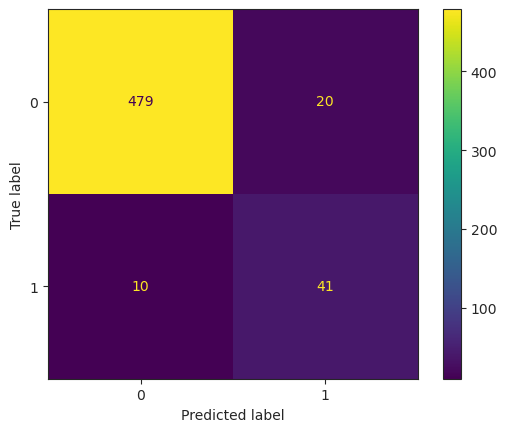

              precision    recall  f1-score   support

         ADL       0.98      0.96      0.97       499
        Fall       0.67      0.80      0.73        51

    accuracy                           0.95       550
   macro avg       0.83      0.88      0.85       550
weighted avg       0.95      0.95      0.95       550

classifier: DrCIFClassifier
Time to train + test (sec): 45.491719831712544
AUC: 0.98


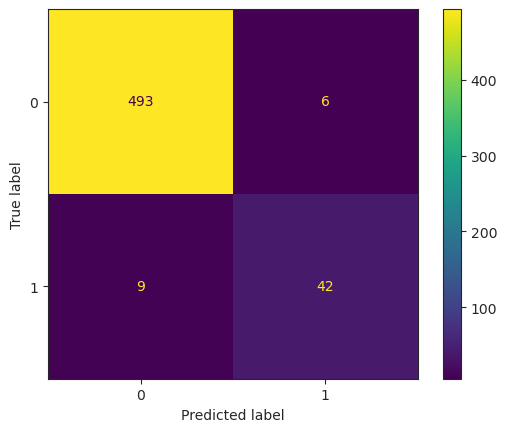

              precision    recall  f1-score   support

         ADL       0.98      0.99      0.99       499
        Fall       0.88      0.82      0.85        51

    accuracy                           0.97       550
   macro avg       0.93      0.91      0.92       550
weighted avg       0.97      0.97      0.97       550



In [19]:
for model in models:
    utils.predict_eval(model, X_in=(X_train, X_test), y_in=(y_train, y_test))